# N-gram language models

In [8]:
import sys
sys.path.append("..")
import ngrams
from nltk import lm
from nltk.lm.preprocessing import padded_everygram_pipeline
import pandas as pd
import numpy as np

from typing import List, Tuple, Dict, Any

from tqdm import tqdm
from collections import defaultdict
import Data
import re
import unicodedata
import json

import matplotlib.pyplot as plt
import sklearn.metrics
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings('ignore', category=UndefinedMetricWarning) 

In [9]:
remove_chars = re.compile(r"[1268\[\],<>&\?]")
space_norm = re.compile(r" +")

def clean_etruscan(x: str) -> str:
    x = x.lower()
    x = Data.replace(x, Data.to_latin)
    x = remove_chars.sub(" ", x)
    x = unicodedata.normalize("NFD", x)
    x = "".join(c for c in x if not unicodedata.combining(c))
    x = unicodedata.normalize("NFC", x)    
    x = space_norm.sub(" ", x)
    return x.strip()

In [10]:
ett = Data.load_lm_dataset(etruscan_fn=clean_etruscan)
etp = Data.load_lm_dataset(etruscan_fn=clean_etruscan, subset="etp")
ciep = Data.load_lm_dataset(etruscan_fn=clean_etruscan, subset="ciep")
ett[:10]

['cleusinas laris larisal clan',
 'mi karkanas thahvna',
 'mi ei minpi capi mi numar thevruclnas qupes fulushla',
 'mini muluvanice tetana velkasnas veleliiasi',
 'itun turuce venel atelinas tinas dlniiaras',
 'mi menervas',
 'vl afuna vl pes nalisha cn shuthi cerikhunce',
 'mi ni mamarce zinace',
 'mi veleli as vheisalna ia',
 'thanakhvil']

In [11]:
"".join(sorted(list(set(" ".join(ett)))))

' -abcdefghiklmnopqrstuvwxyz'

In [12]:
def print_stats(results):
    df = pd.DataFrame(results)
    print("Mean:")
    print(df.mean())
    print("Standar deviation:")
    print(df.std())
    
def random_split(etruscan: List[str], ratio:float, rng: np.random.RandomState) -> Tuple[List[str], List[str]]:
    """Split the dataset in train and test"""
    indexes = np.arange(len(etruscan))
    rng.shuffle(indexes)
    split = int(np.round(ratio * len(indexes)))
        
    train = []
    for i in indexes[:split]:        
        train.append(etruscan[i])
    
    test = []
    for i in indexes[split:]:        
        test.append(etruscan[i])

    return train, test

def run_experiment(        
        train: List[str],         
        test: List[str],  
        n: int,       
        tokenizer: Data.TokenizerType,  
        base_model: Any, 
        examples:int = 1
    ) -> Tuple[Dict[str, float], Tuple[List[str], List[str]]]:
    model = ngrams.NgramLmModel(n, tokenizer, base_model)
    model.train(train)

    # TODO: warn when computing PPL
    ppl, _ = ngrams.compute_perplexity(test, model)
    scores = {"PPL": ppl}
    # Estimate number of tokens to generate
    avg_len = max(1, int(np.ceil(sum([len(i.split(" ")) for i in train]) / len(train) - model.n)))
    pred = []
    for i in range(examples):
        # Use the first 4 tokens
        tmp = model._tokenizer.tokenize(test[i])[:4]
        pred.append(model.predict(tmp, stop_eos=True, n=avg_len))

    ex = (test[:examples], pred)

    # Reconstruction
    actual = []
    prediction = []
    for i in test:
        tokens = model._tokenizer.tokenize(i) # BOS _ token1 token2 
        # Predict next token and compare
        # Add one token at the time,
        # Not autoregressive         
        for j in range(3, len(tokens)-1):
            toks = tokens[:j]
            prediction.append(model._lm.generate(num_words=1, text_seed=toks, random_seed=0))
            actual.append(tokens[j])
    # print(actual)
    # print(prediction)
    # confusion = sklearn.metrics.confusion_matrix(actual, prediction)
    scores["Accuracy"] = sklearn.metrics.accuracy_score(actual, prediction)
    scores["Precision"] = sklearn.metrics.precision_score(actual, prediction, average="macro")
    scores["Recall"] = sklearn.metrics.recall_score(actual, prediction, average="macro")
    scores["F1-Score"] = sklearn.metrics.f1_score(actual, prediction, average="macro")

    # Scores when the target word is known and exclude spaces
    tmp = [(i, j) for i, j in zip(actual, prediction) if "-" not in i and "▁" not in i]
    actual, prediction = zip(*tmp)
    scores["Accuracy_words"] = sklearn.metrics.accuracy_score(actual, prediction)
    scores["Precision_words"] = sklearn.metrics.precision_score(actual, prediction, average="macro")
    scores["Recall_words"] = sklearn.metrics.recall_score(actual, prediction, average="macro")
    scores["F1-Score_words"] = sklearn.metrics.f1_score(actual, prediction, average="macro")
    return scores, ex

def run_n_experiments(
        ett: List[str],
        tokenizer: Data.TokenizerType, 
        base_model: Any,   
        ngram: int = 2,  
        runs: int = 10, 
        seed: int = 0,
        examples: int = 3
    ) -> Tuple[Dict[str, List[float]], Tuple[List[str], List[str]]]:

    results = defaultdict(list)
    rng = np.random.RandomState(seed)

    for _ in tqdm(range(runs), total=runs):
        train, test = random_split(ett, 0.8, rng)
        
        tmp_res, example = run_experiment(train, test, ngram, tokenizer, base_model, examples)
        for i, j in tmp_res.items():
            results[i].append(j)
    
    return results, example

def plot_results(results: Dict[str, List[float]], title, figsize=(6, 5)) -> None:
    fig, ax = plt.subplots(1, 1,figsize=figsize)    
    
    ax.boxplot(results["PPL"])
    ax.set_xticklabels(["PPL"])        
    ax.grid()
    fig.suptitle(title)
    plt.show()

    fig, ax = plt.subplots(1, 1,figsize=figsize)    
    
    labels = ["Accuracy", "Precision", "Recall", "F1-Score", "Accuracy_words", "Precision_words", "Recall_words", "F1-Score_words"]
    ax.boxplot([results[i] for i in labels])
    ax.set_xticklabels(labels, rotation=90)        
    ax.grid()
    fig.suptitle(title)
    plt.show()


def print_examples(examples: Tuple[List[str], List[str], List[str]]) -> None:
    n = len(examples[0])
    for i in range(n):
        # print("-" * 60)
        print("Etruscan:", examples[0][i])
        print("Prediction:", examples[1][i])
        # print("-" * 60)

def do_job(order: List[int], gamma: List[float], data: List[str], tokenizer: Data.TokenizerType, output: str):
    for n in order:
        for g in gamma:
            name = output.format(n, g)
            print("-" * 60)
            print(name, "\n")
            scores, examples = run_n_experiments(data, tokenizer, ngrams.LMWrapper(lm.Lidstone, gamma=g), ngram=n)

            # Save example
            with open("Results/" + name, "w") as f:
                json.dump(scores, f)


            print_stats(scores)
            print_examples(examples)
            plot_results(scores, name)

def print_vocab_size(tokenizer: Data.TokenizerType, data: List[str]):
    train, test = random_split(data, 0.8, np.random.RandomState(0))

    train = [tokenizer.tokenize(i) for i in train]
    test = [tokenizer.tokenize(i) for i in test]
    all = [tokenizer.tokenize(i) for i in data]

    _, train_vocab = padded_everygram_pipeline(1, train)
    _, test_vocab = padded_everygram_pipeline(1, test)
    _, all_vocab = padded_everygram_pipeline(1, all)

    print("Estimate train voc. size:", len(list(train_vocab)))
    print("Estimate test voc. size:", len(list(test_vocab)))
    print("Voc. size:", len(list(all_vocab)))

## WhiteSpace tokenizer

### ETP+CIEP

In [13]:
tokenizer = Data.BlankspaceTokenizer()
print_vocab_size(tokenizer, ett)

Estimate train voc. size: 8664
Estimate test voc. size: 2088
Voc. size: 10752


------------------------------------------------------------
1-ngram - WhiteSpace tokenizer - gamma 0.1 - ETPCIEP 



100%|██████████| 10/10 [00:38<00:00,  3.82s/it]

Mean:
PPL                52026.970436
Accuracy               0.000000
Precision              0.000000
Recall                 0.000000
F1-Score               0.000000
Accuracy_words         0.000000
Precision_words        0.000000
Recall_words           0.000000
F1-Score_words         0.000000
dtype: float64
Standar deviation:
PPL                1211.565221
Accuracy              0.000000
Precision             0.000000
Recall                0.000000
F1-Score              0.000000
Accuracy_words        0.000000
Precision_words       0.000000
Recall_words          0.000000
F1-Score_words        0.000000
dtype: float64
Etruscan: uzinas
Prediction: uzinas tiuza
Etruscan: alpnu
Prediction: alpnu tiuza
Etruscan: --------e----------------------ndvmqv------------------
Prediction: --------e----------------------ndvmqv------------------ tiuza


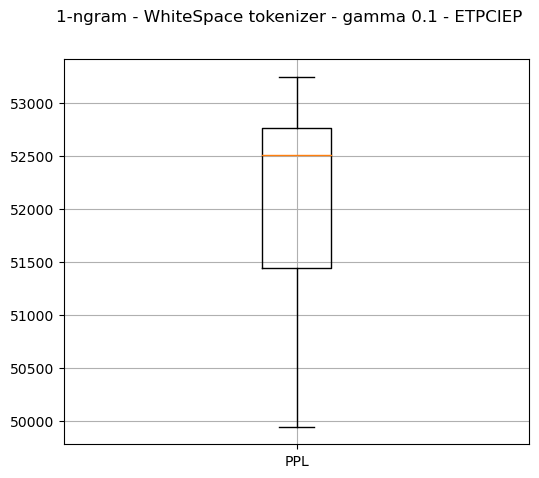

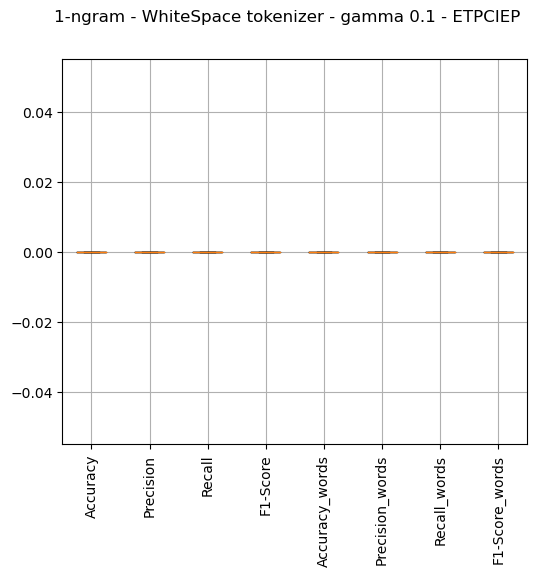

------------------------------------------------------------
1-ngram - WhiteSpace tokenizer - gamma 0.5 - ETPCIEP 



100%|██████████| 10/10 [00:40<00:00,  4.06s/it]

Mean:
PPL                14297.006718
Accuracy               0.000000
Precision              0.000000
Recall                 0.000000
F1-Score               0.000000
Accuracy_words         0.000000
Precision_words        0.000000
Recall_words           0.000000
F1-Score_words         0.000000
dtype: float64
Standar deviation:
PPL                267.313959
Accuracy             0.000000
Precision            0.000000
Recall               0.000000
F1-Score             0.000000
Accuracy_words       0.000000
Precision_words      0.000000
Recall_words         0.000000
F1-Score_words       0.000000
dtype: float64
Etruscan: uzinas
Prediction: uzinas titprla
Etruscan: alpnu
Prediction: alpnu titprla
Etruscan: --------e----------------------ndvmqv------------------
Prediction: --------e----------------------ndvmqv------------------ titprla


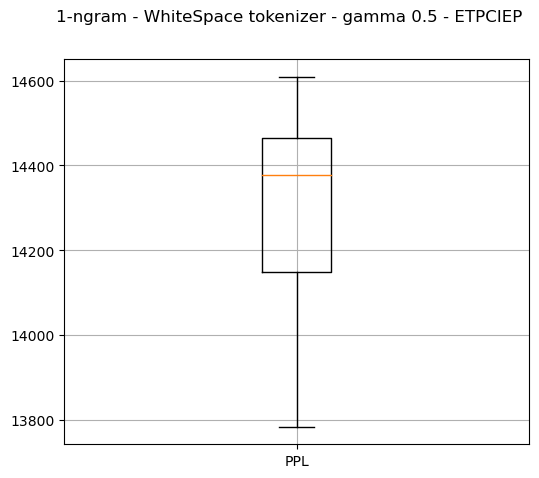

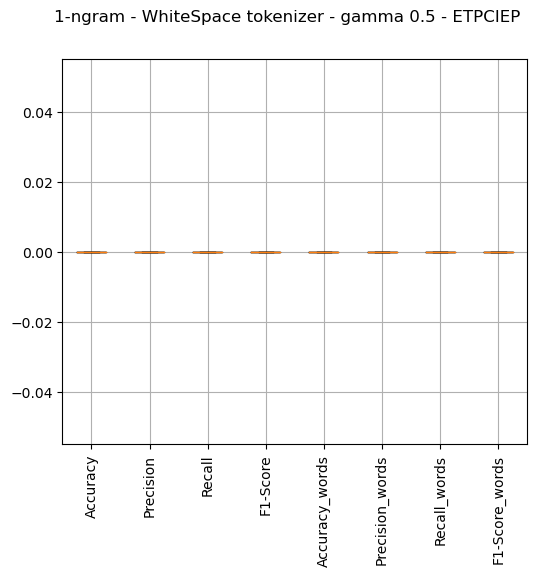

------------------------------------------------------------
1-ngram - WhiteSpace tokenizer - gamma 1 - ETPCIEP 



100%|██████████| 10/10 [00:30<00:00,  3.08s/it]

Mean:
PPL                9520.609731
Accuracy              0.000000
Precision             0.000000
Recall                0.000000
F1-Score              0.000000
Accuracy_words        0.000000
Precision_words       0.000000
Recall_words          0.000000
F1-Score_words        0.000000
dtype: float64
Standar deviation:
PPL                151.735125
Accuracy             0.000000
Precision            0.000000
Recall               0.000000
F1-Score             0.000000
Accuracy_words       0.000000
Precision_words      0.000000
Recall_words         0.000000
F1-Score_words       0.000000
dtype: float64
Etruscan: uzinas
Prediction: uzinas titis
Etruscan: alpnu
Prediction: alpnu titis
Etruscan: --------e----------------------ndvmqv------------------
Prediction: --------e----------------------ndvmqv------------------ titis


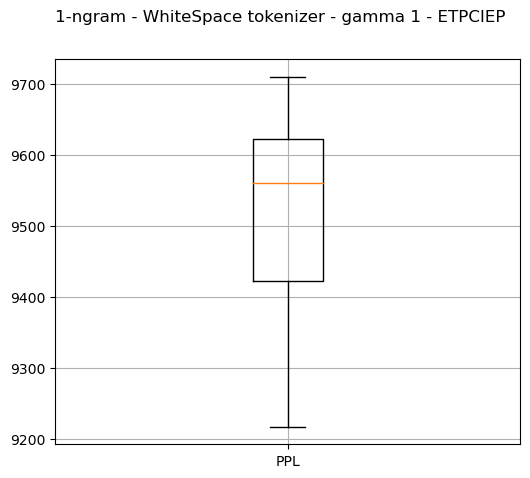

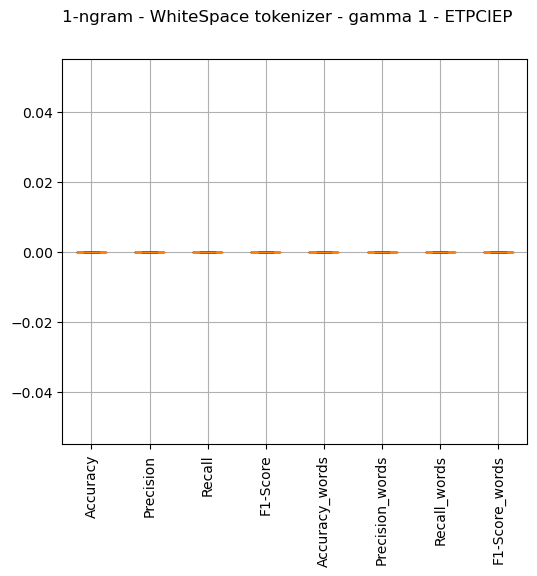

------------------------------------------------------------
2-ngram - WhiteSpace tokenizer - gamma 0.1 - ETPCIEP 



100%|██████████| 10/10 [00:16<00:00,  1.63s/it]

Mean:
PPL                10765.094303
Accuracy               0.139717
Precision              0.117270
Recall                 0.114490
F1-Score               0.111315
Accuracy_words         0.142640
Precision_words        0.117299
Recall_words           0.115202
F1-Score_words         0.111820
dtype: float64
Standar deviation:
PPL                161.554906
Accuracy             0.043908
Precision            0.038103
Recall               0.035847
F1-Score             0.035977
Accuracy_words       0.042607
Precision_words      0.037401
Recall_words         0.034773
F1-Score_words       0.034942
dtype: float64
Etruscan: uzinas
Prediction: uzinas pumpuial
Etruscan: alpnu
Prediction: alpnu
Etruscan: --------e----------------------ndvmqv------------------
Prediction: --------e----------------------ndvmqv------------------ pumpuial


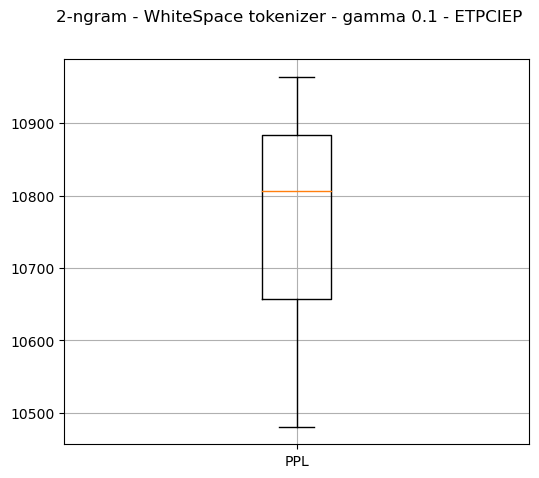

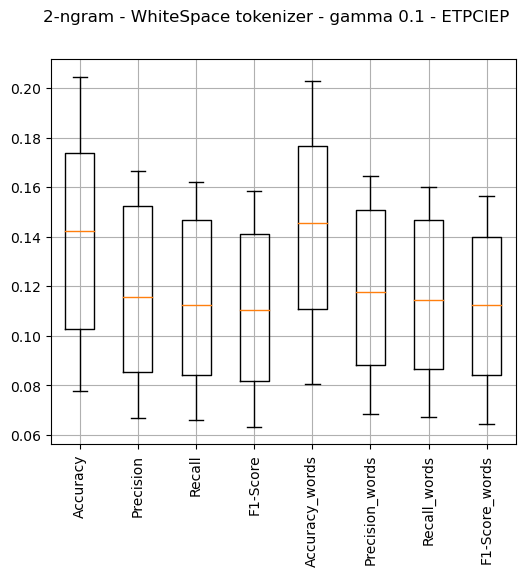

------------------------------------------------------------
2-ngram - WhiteSpace tokenizer - gamma 0.5 - ETPCIEP 



100%|██████████| 10/10 [00:17<00:00,  1.70s/it]

Mean:
PPL                6346.327747
Accuracy              0.137205
Precision             0.117474
Recall                0.112719
F1-Score              0.110254
Accuracy_words        0.139999
Precision_words       0.117472
Recall_words          0.113349
F1-Score_words        0.110700
dtype: float64
Standar deviation:
PPL                71.617632
Accuracy            0.044722
Precision           0.038275
Recall              0.036611
F1-Score            0.036381
Accuracy_words      0.043381
Precision_words     0.037635
Recall_words        0.035583
F1-Score_words      0.035377
dtype: float64
Etruscan: uzinas
Prediction: uzinas ril
Etruscan: alpnu
Prediction: alpnu
Etruscan: --------e----------------------ndvmqv------------------
Prediction: --------e----------------------ndvmqv------------------ ril


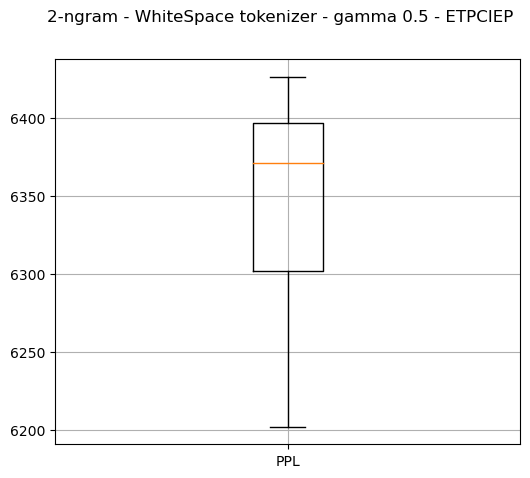

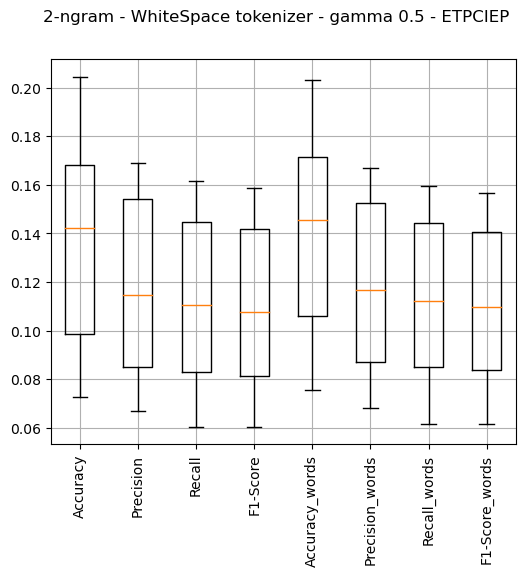

------------------------------------------------------------
2-ngram - WhiteSpace tokenizer - gamma 1 - ETPCIEP 



100%|██████████| 10/10 [00:16<00:00,  1.61s/it]

Mean:
PPL                5579.954680
Accuracy              0.133674
Precision             0.114483
Recall                0.109062
F1-Score              0.107132
Accuracy_words        0.136343
Precision_words       0.114433
Recall_words          0.109631
F1-Score_words        0.107524
dtype: float64
Standar deviation:
PPL                53.407280
Accuracy            0.042551
Precision           0.036292
Recall              0.033890
F1-Score            0.034357
Accuracy_words      0.041177
Precision_words     0.035653
Recall_words        0.032810
F1-Score_words      0.033339
dtype: float64
Etruscan: uzinas
Prediction: uzinas scurna
Etruscan: alpnu
Prediction: alpnu
Etruscan: --------e----------------------ndvmqv------------------
Prediction: --------e----------------------ndvmqv------------------ scurna


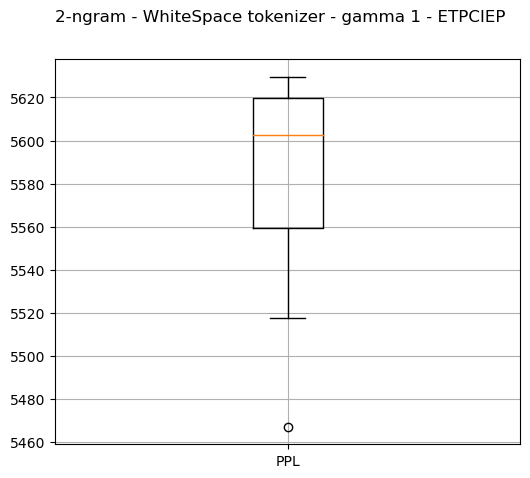

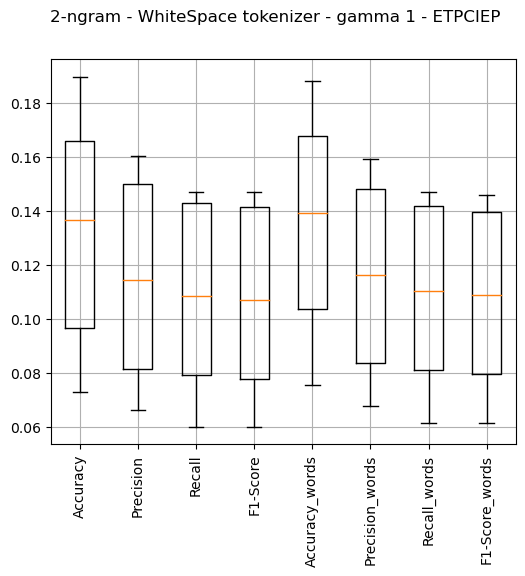

------------------------------------------------------------
3-ngram - WhiteSpace tokenizer - gamma 0.1 - ETPCIEP 



100%|██████████| 10/10 [00:20<00:00,  2.04s/it]

Mean:
PPL                7437.162193
Accuracy              0.215501
Precision             0.189233
Recall                0.182438
F1-Score              0.180431
Accuracy_words        0.221353
Precision_words       0.191038
Recall_words          0.184552
F1-Score_words        0.182386
dtype: float64
Standar deviation:
PPL                92.165204
Accuracy            0.065713
Precision           0.056439
Recall              0.053560
F1-Score            0.054572
Accuracy_words      0.064927
Precision_words     0.055774
Recall_words        0.052859
F1-Score_words      0.053899
dtype: float64
Etruscan: uzinas
Prediction: uzinas lautnial
Etruscan: alpnu
Prediction: alpnu
Etruscan: --------e----------------------ndvmqv------------------
Prediction: --------e----------------------ndvmqv------------------ lautnial


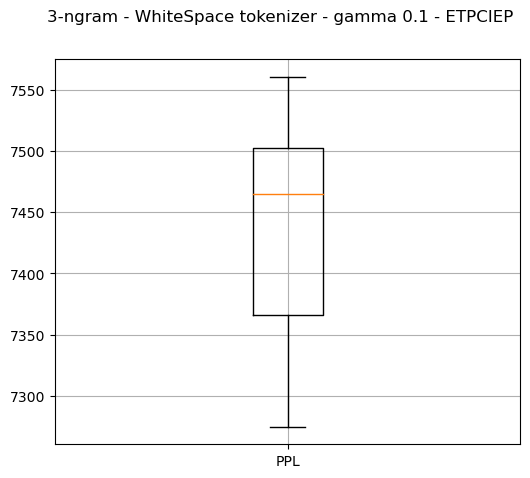

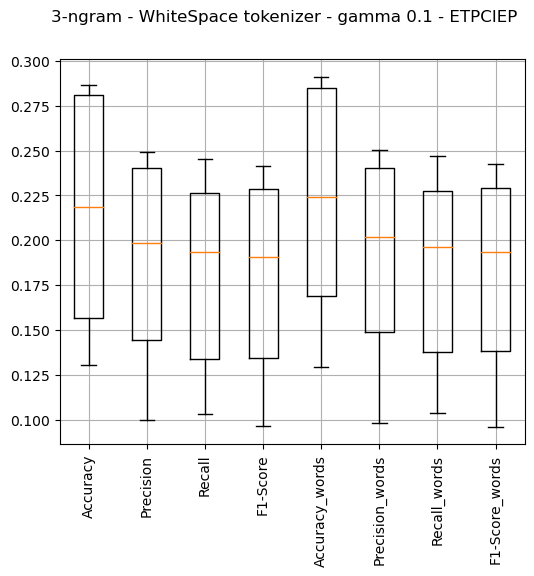

------------------------------------------------------------
3-ngram - WhiteSpace tokenizer - gamma 0.5 - ETPCIEP 



100%|██████████| 10/10 [00:18<00:00,  1.87s/it]

Mean:
PPL                5433.831116
Accuracy              0.215036
Precision             0.190168
Recall                0.182015
F1-Score              0.180497
Accuracy_words        0.220871
Precision_words       0.191907
Recall_words          0.184027
F1-Score_words        0.182368
dtype: float64
Standar deviation:
PPL                49.364226
Accuracy            0.066176
Precision           0.056138
Recall              0.053794
F1-Score            0.054205
Accuracy_words      0.065389
Precision_words     0.055523
Recall_words        0.053114
F1-Score_words      0.053565
dtype: float64
Etruscan: uzinas
Prediction: uzinas mifaltus
Etruscan: alpnu
Prediction: alpnu
Etruscan: --------e----------------------ndvmqv------------------
Prediction: --------e----------------------ndvmqv------------------ mifaltus


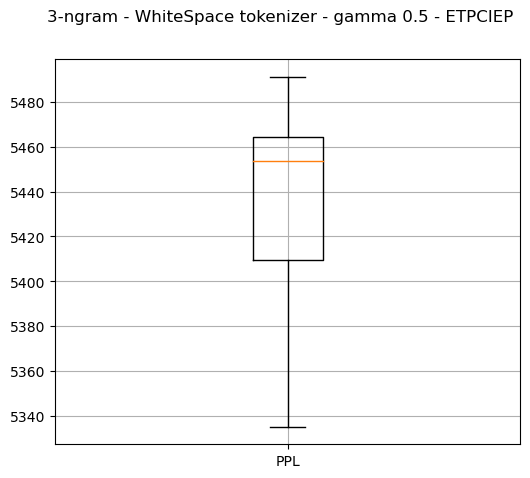

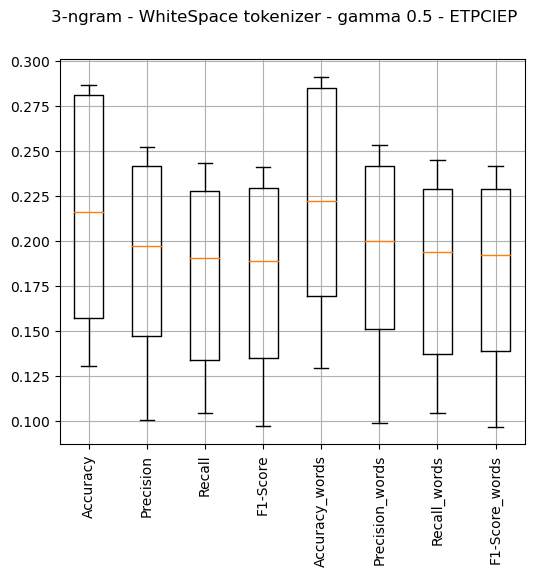

------------------------------------------------------------
3-ngram - WhiteSpace tokenizer - gamma 1 - ETPCIEP 



100%|██████████| 10/10 [00:19<00:00,  2.00s/it]

Mean:
PPL                5093.893985
Accuracy              0.214657
Precision             0.190873
Recall                0.181756
F1-Score              0.180994
Accuracy_words        0.220479
Precision_words       0.192623
Recall_words          0.183756
F1-Score_words        0.182871
dtype: float64
Standar deviation:
PPL                39.682585
Accuracy            0.066012
Precision           0.056746
Recall              0.053764
F1-Score            0.054689
Accuracy_words      0.065226
Precision_words     0.056137
Recall_words        0.053063
F1-Score_words      0.054050
dtype: float64
Etruscan: uzinas
Prediction: uzinas onios
Etruscan: alpnu
Prediction: alpnu
Etruscan: --------e----------------------ndvmqv------------------
Prediction: --------e----------------------ndvmqv------------------ onios


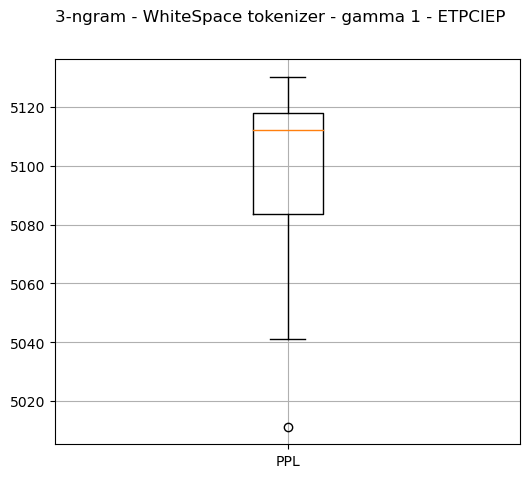

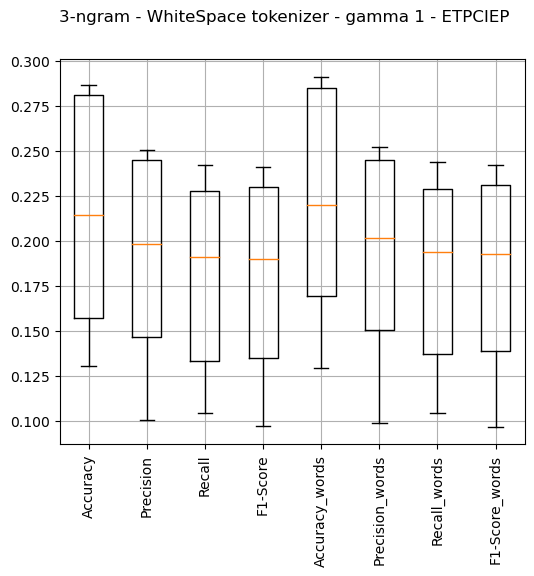

In [14]:
tokenizer = Data.BlankspaceTokenizer()
output = "{}-ngram - WhiteSpace tokenizer - gamma {} - ETPCIEP"

order = [1,2,3]
gamma = [0.1, 0.5, 1]

do_job(order, gamma, ett, tokenizer, output)

### ETP

In [15]:
tokenizer = Data.BlankspaceTokenizer()
print_vocab_size(tokenizer, etp)

Estimate train voc. size: 2114
Estimate test voc. size: 742
Voc. size: 2856


------------------------------------------------------------
1-ngram - WhiteSpace tokenizer - gamma 0.1 - ETP 



100%|██████████| 10/10 [00:17<00:00,  1.74s/it]

Mean:
PPL                4851.446698
Accuracy              0.000985
Precision             0.000005
Recall                0.001286
F1-Score              0.000009
Accuracy_words        0.001031
Precision_words       0.000005
Recall_words          0.001329
F1-Score_words        0.000010
dtype: float64
Standar deviation:
PPL                888.536140
Accuracy             0.001718
Precision            0.000010
Recall               0.002227
F1-Score             0.000019
Accuracy_words       0.001811
Precision_words      0.000011
Recall_words         0.002307
F1-Score_words       0.000021
dtype: float64
Etruscan: tite
Prediction: tite tulumnesh suthina larthal curunas
Etruscan: zathrumsne lushash fler hamphisca thezeri
Prediction: zathrumsne lushash fler hamphisca tulumnesh suthina larthal curunas
Etruscan: --- mvkhza
Prediction: --- mvkhza tulumnesh suthina larthal curunas


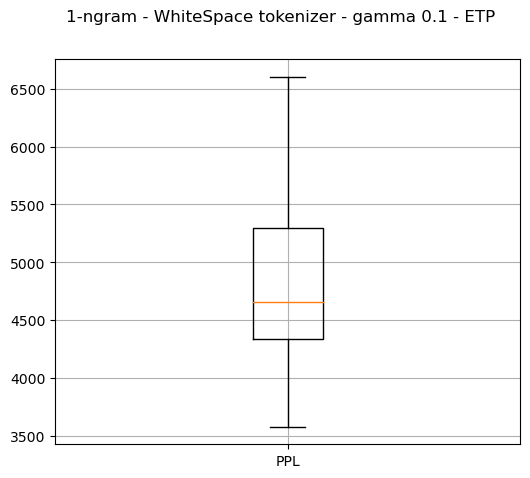

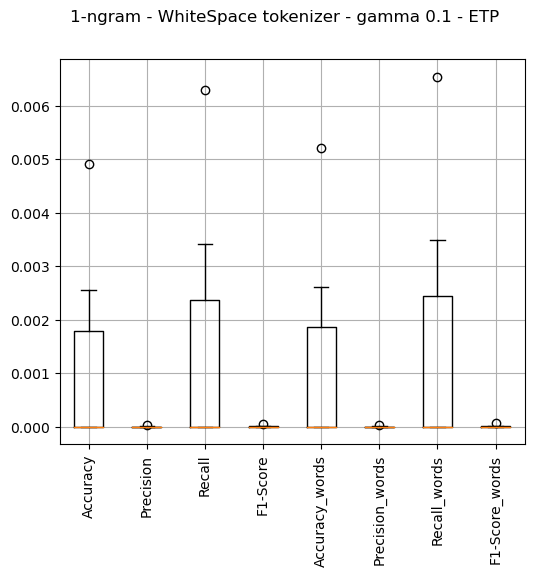

------------------------------------------------------------
1-ngram - WhiteSpace tokenizer - gamma 0.5 - ETP 



100%|██████████| 10/10 [00:16<00:00,  1.65s/it]

Mean:
PPL                1695.368073
Accuracy              0.001012
Precision             0.000005
Recall                0.001326
F1-Score              0.000010
Accuracy_words        0.001060
Precision_words       0.000005
Recall_words          0.001371
F1-Score_words        0.000011
dtype: float64
Standar deviation:
PPL                209.663953
Accuracy             0.001745
Precision            0.000010
Recall               0.002268
F1-Score             0.000020
Accuracy_words       0.001840
Precision_words      0.000011
Recall_words         0.002349
F1-Score_words       0.000022
dtype: float64
Etruscan: tite
Prediction: tite tur svalce larthial e
Etruscan: zathrumsne lushash fler hamphisca thezeri
Prediction: zathrumsne lushash fler hamphisca tur svalce larthial e
Etruscan: --- mvkhza
Prediction: --- mvkhza tur svalce larthial e


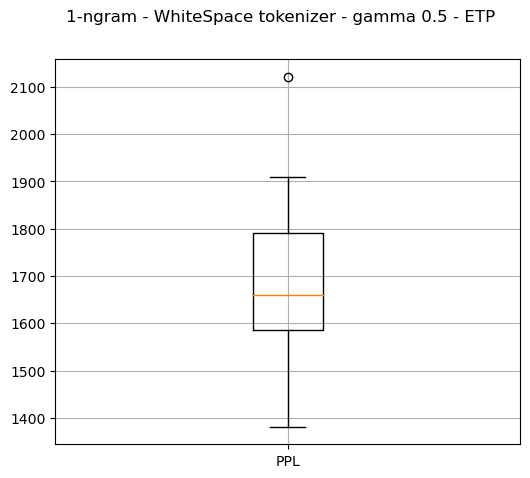

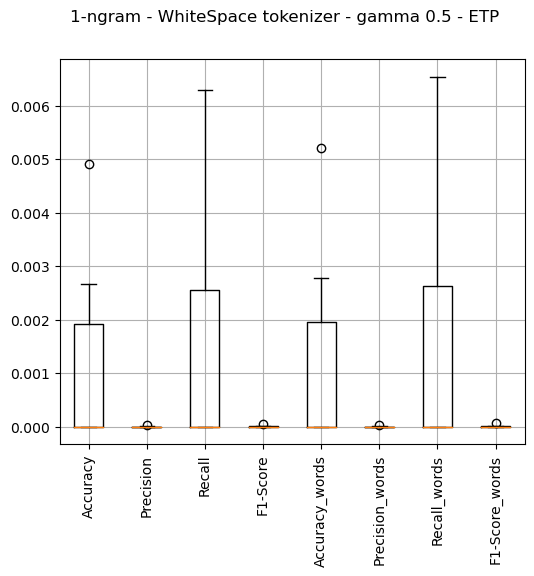

------------------------------------------------------------
1-ngram - WhiteSpace tokenizer - gamma 1 - ETP 



100%|██████████| 10/10 [00:17<00:00,  1.75s/it]

Mean:
PPL                1244.165449
Accuracy              0.001286
Precision             0.000007
Recall                0.001638
F1-Score              0.000015
Accuracy_words        0.001331
Precision_words       0.000008
Recall_words          0.001679
F1-Score_words        0.000016
dtype: float64
Standar deviation:
PPL                124.415361
Accuracy             0.002176
Precision            0.000014
Recall               0.002751
F1-Score             0.000027
Accuracy_words       0.002247
Precision_words      0.000014
Recall_words         0.002815
F1-Score_words       0.000029
dtype: float64
Etruscan: tite
Prediction: tite tur t larusi ealc
Etruscan: zathrumsne lushash fler hamphisca thezeri
Prediction: zathrumsne lushash fler hamphisca tur t larusi ealc
Etruscan: --- mvkhza
Prediction: --- mvkhza tur t larusi ealc


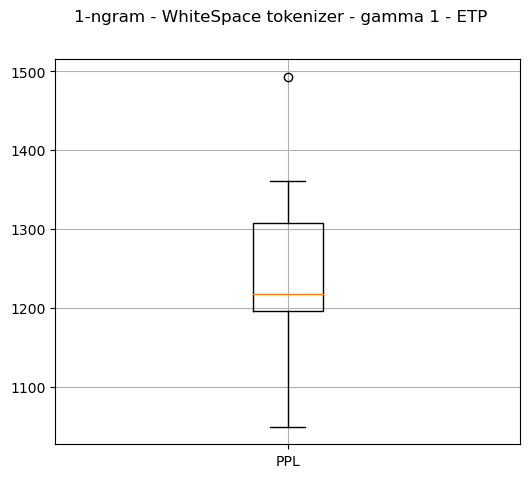

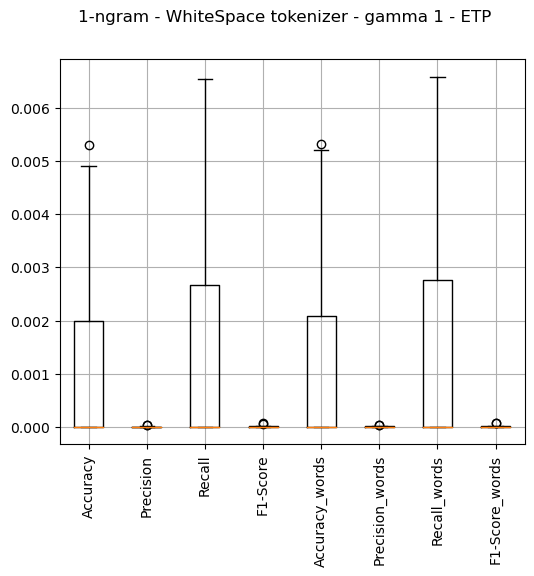

------------------------------------------------------------
2-ngram - WhiteSpace tokenizer - gamma 0.1 - ETP 



100%|██████████| 10/10 [00:04<00:00,  2.33it/s]

Mean:
PPL                767.689454
Accuracy             0.143558
Precision            0.122974
Recall               0.119957
F1-Score             0.116410
Accuracy_words       0.147170
Precision_words      0.124701
Recall_words         0.121982
F1-Score_words       0.118251
dtype: float64
Standar deviation:
PPL                106.181870
Accuracy             0.055017
Precision            0.049326
Recall               0.046589
F1-Score             0.047710
Accuracy_words       0.055534
Precision_words      0.049809
Recall_words         0.046737
F1-Score_words       0.047993
dtype: float64
Etruscan: tite
Prediction: tite utaves v l
Etruscan: zathrumsne lushash fler hamphisca thezeri
Prediction: zathrumsne lushash fler hamphisca thezeri
Etruscan: --- mvkhza
Prediction: --- mvkhza th shuthith acazrce


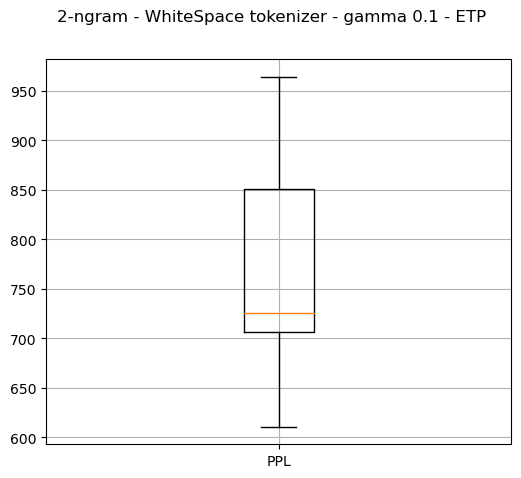

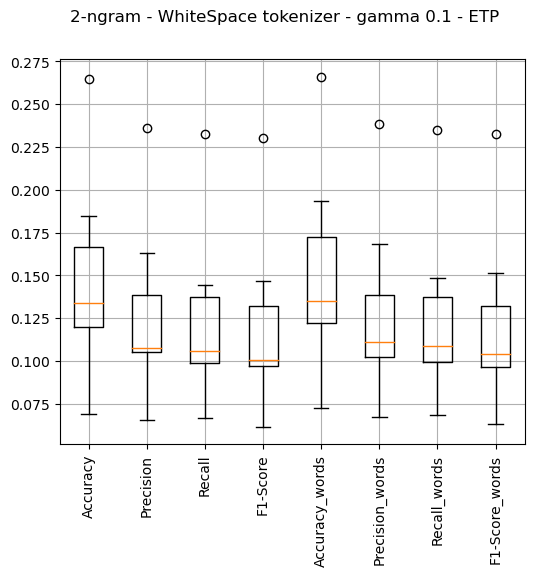

------------------------------------------------------------
2-ngram - WhiteSpace tokenizer - gamma 0.5 - ETP 



100%|██████████| 10/10 [00:04<00:00,  2.17it/s]

Mean:
PPL                707.820337
Accuracy             0.142522
Precision            0.122274
Recall               0.118675
F1-Score             0.115602
Accuracy_words       0.146105
Precision_words      0.123997
Recall_words         0.120681
F1-Score_words       0.117435
dtype: float64
Standar deviation:
PPL                68.526464
Accuracy            0.053486
Precision           0.046421
Recall              0.044049
F1-Score            0.044891
Accuracy_words      0.053996
Precision_words     0.046875
Recall_words        0.044187
F1-Score_words      0.045151
dtype: float64
Etruscan: tite
Prediction: tite utaves v l
Etruscan: zathrumsne lushash fler hamphisca thezeri
Prediction: zathrumsne lushash fler hamphisca thezeri
Etruscan: --- mvkhza
Prediction: --- mvkhza thana punp nas


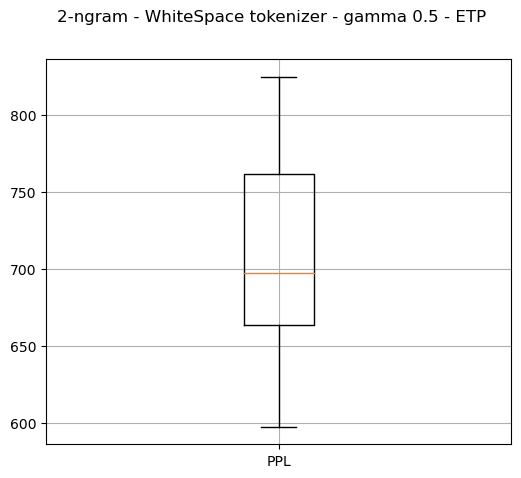

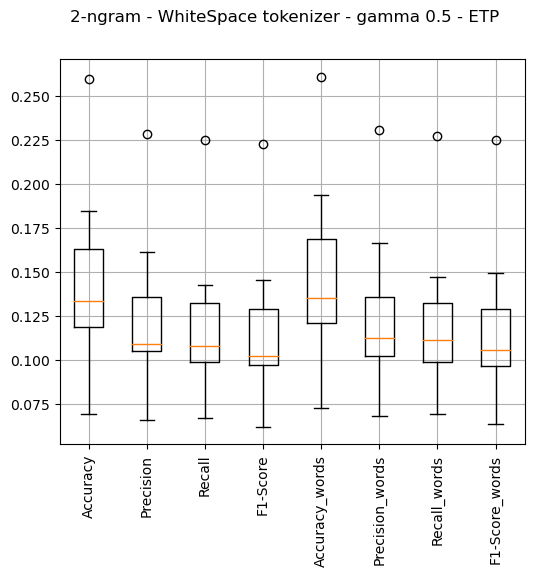

------------------------------------------------------------
2-ngram - WhiteSpace tokenizer - gamma 1 - ETP 



100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

Mean:
PPL                741.778509
Accuracy             0.142904
Precision            0.122070
Recall               0.119272
F1-Score             0.115568
Accuracy_words       0.146511
Precision_words      0.123797
Recall_words         0.121301
F1-Score_words       0.117407
dtype: float64
Standar deviation:
PPL                61.130607
Accuracy            0.054220
Precision           0.046907
Recall              0.044760
F1-Score            0.045253
Accuracy_words      0.054828
Precision_words     0.047413
Recall_words        0.044955
F1-Score_words      0.045532
dtype: float64
Etruscan: tite
Prediction: tite utaves v l
Etruscan: zathrumsne lushash fler hamphisca thezeri
Prediction: zathrumsne lushash fler hamphisca thezeri
Etruscan: --- mvkhza
Prediction: --- mvkhza thelmizas s mu


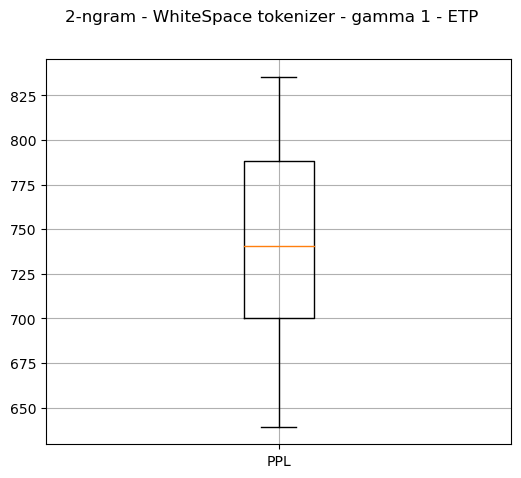

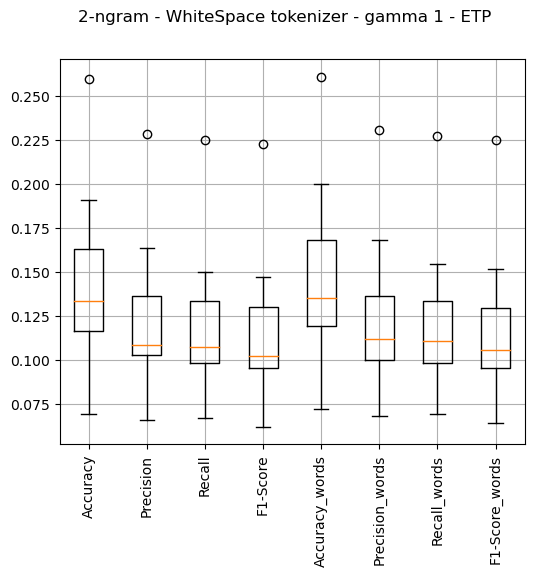

------------------------------------------------------------
3-ngram - WhiteSpace tokenizer - gamma 0.1 - ETP 



100%|██████████| 10/10 [00:04<00:00,  2.05it/s]

Mean:
PPL                741.107089
Accuracy             0.196425
Precision            0.169931
Recall               0.165665
F1-Score             0.162382
Accuracy_words       0.201987
Precision_words      0.172908
Recall_words         0.168911
F1-Score_words       0.165446
dtype: float64
Standar deviation:
PPL                88.834562
Accuracy            0.061246
Precision           0.053061
Recall              0.051682
F1-Score            0.052256
Accuracy_words      0.061845
Precision_words     0.053126
Recall_words        0.051569
F1-Score_words      0.052218
dtype: float64
Etruscan: tite
Prediction: tite utaves v
Etruscan: zathrumsne lushash fler hamphisca thezeri
Prediction: zathrumsne lushash fler hamphisca thezeri
Etruscan: --- mvkhza
Prediction: --- mvkhza sethrna cracias


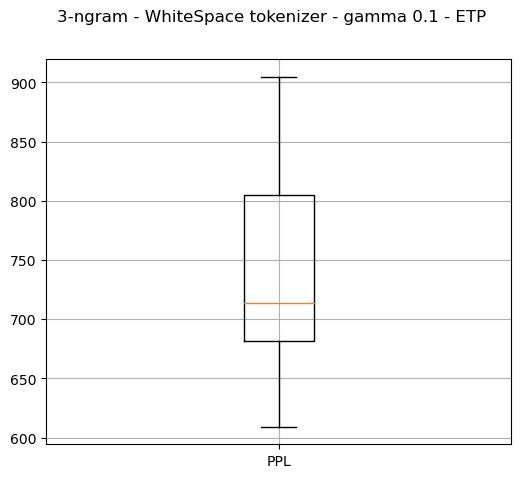

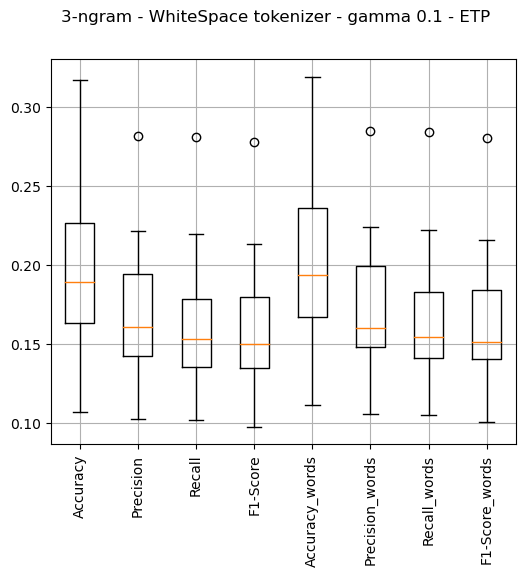

------------------------------------------------------------
3-ngram - WhiteSpace tokenizer - gamma 0.5 - ETP 



100%|██████████| 10/10 [00:05<00:00,  1.99it/s]

Mean:
PPL                737.825554
Accuracy             0.196425
Precision            0.170587
Recall               0.165304
F1-Score             0.163068
Accuracy_words       0.201987
Precision_words      0.173579
Recall_words         0.168537
F1-Score_words       0.166149
dtype: float64
Standar deviation:
PPL                65.766251
Accuracy            0.061246
Precision           0.051818
Recall              0.051208
F1-Score            0.051329
Accuracy_words      0.061845
Precision_words     0.051845
Recall_words        0.051072
F1-Score_words      0.051261
dtype: float64
Etruscan: tite
Prediction: tite utaves v
Etruscan: zathrumsne lushash fler hamphisca thezeri
Prediction: zathrumsne lushash fler hamphisca thezeri
Etruscan: --- mvkhza
Prediction: --- mvkhza spantus sekh


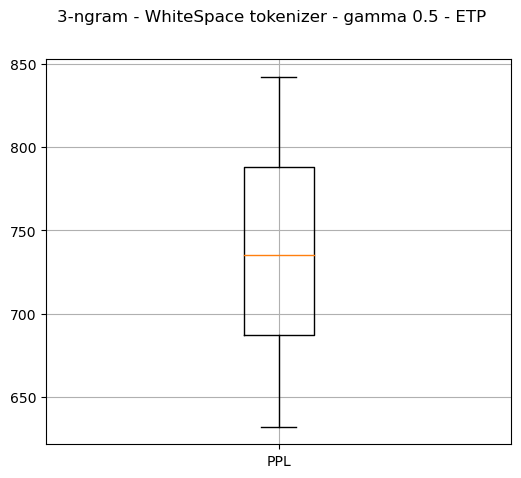

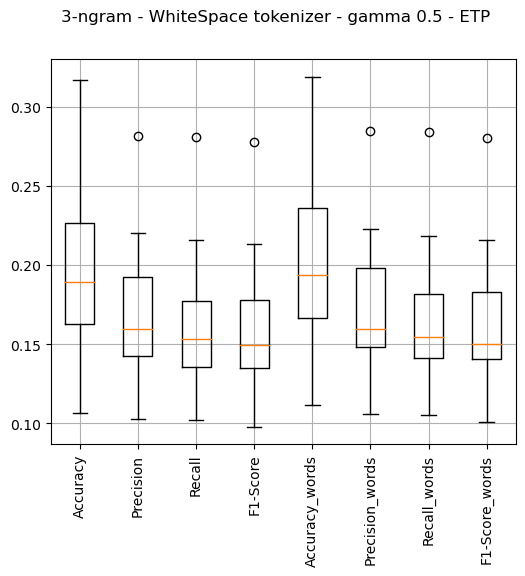

------------------------------------------------------------
3-ngram - WhiteSpace tokenizer - gamma 1 - ETP 



100%|██████████| 10/10 [00:05<00:00,  1.71it/s]

Mean:
PPL                777.928075
Accuracy             0.196425
Precision            0.171004
Recall               0.165782
F1-Score             0.163598
Accuracy_words       0.201987
Precision_words      0.174015
Recall_words         0.169034
F1-Score_words       0.166698
dtype: float64
Standar deviation:
PPL                60.251985
Accuracy            0.061246
Precision           0.052062
Recall              0.051448
F1-Score            0.051538
Accuracy_words      0.061845
Precision_words     0.052135
Recall_words        0.051319
F1-Score_words      0.051481
dtype: float64
Etruscan: tite
Prediction: tite utaves v
Etruscan: zathrumsne lushash fler hamphisca thezeri
Prediction: zathrumsne lushash fler hamphisca thezeri
Etruscan: --- mvkhza
Prediction: --- mvkhza svalce avil


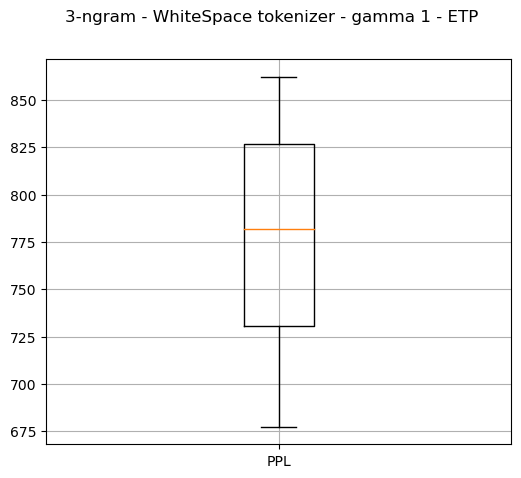

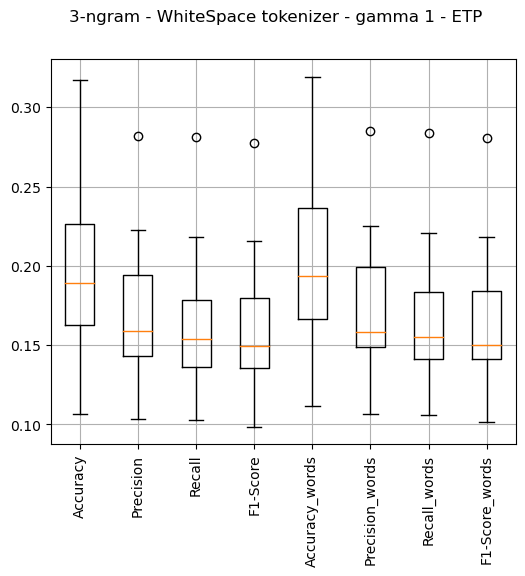

In [16]:
tokenizer = Data.BlankspaceTokenizer()
output = "{}-ngram - WhiteSpace tokenizer - gamma {} - ETP"

do_job(order, gamma, etp, tokenizer, output)

## Suffix tokenizer

### ETP+CIEP

In [17]:
tokenizer = Data.SuffixTokenizer()
print_vocab_size(tokenizer, ett)

Estimate train voc. size: 18848
Estimate test voc. size: 4524
Voc. size: 23372


------------------------------------------------------------
1-ngram - Suffix tokenizer - gamma 0.1 - ETPCIEP 



  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:58<00:00, 11.81s/it]

Mean:
PPL                15414.093459
Accuracy               0.013319
Precision              0.000042
Recall                 0.003202
F1-Score               0.000083
Accuracy_words         0.013448
Precision_words        0.000043
Recall_words           0.003252
F1-Score_words         0.000085
dtype: float64
Standar deviation:
PPL                1120.301355
Accuracy              0.004130
Precision             0.000012
Recall                0.000223
F1-Score              0.000023
Accuracy_words        0.004157
Precision_words       0.000012
Recall_words          0.000223
F1-Score_words        0.000023
dtype: float64
Etruscan: uzinas
Prediction: uzinasth
Etruscan: alpnu
Prediction: alpnuth
Etruscan: --------e----------------------ndvmqv------------------
Prediction: --------e----------------------ndvmqv------------------th


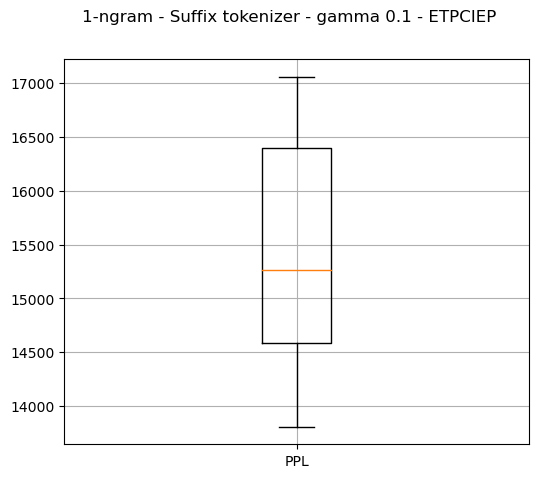

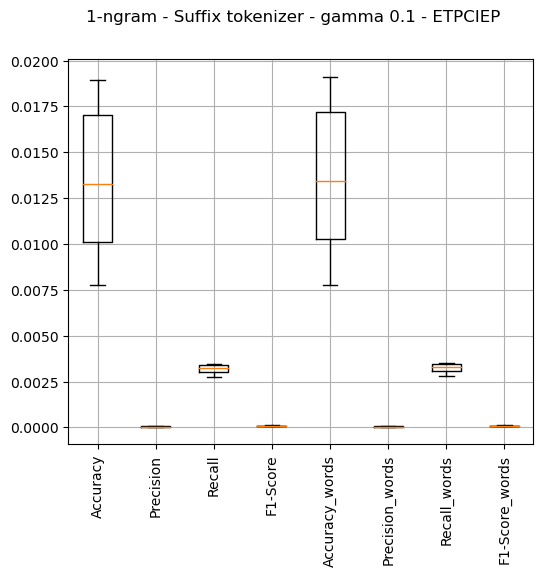

------------------------------------------------------------
1-ngram - Suffix tokenizer - gamma 0.5 - ETPCIEP 



100%|██████████| 10/10 [01:40<00:00, 10.04s/it]

Mean:
PPL                4024.727899
Accuracy              0.013319
Precision             0.000042
Recall                0.003202
F1-Score              0.000083
Accuracy_words        0.013448
Precision_words       0.000043
Recall_words          0.003252
F1-Score_words        0.000085
dtype: float64
Standar deviation:
PPL                259.683277
Accuracy             0.004130
Precision            0.000012
Recall               0.000223
F1-Score             0.000023
Accuracy_words       0.004157
Precision_words      0.000012
Recall_words         0.000223
F1-Score_words       0.000023
dtype: float64
Etruscan: uzinas
Prediction: uzinasth
Etruscan: alpnu
Prediction: alpnuth
Etruscan: --------e----------------------ndvmqv------------------
Prediction: --------e----------------------ndvmqv------------------th


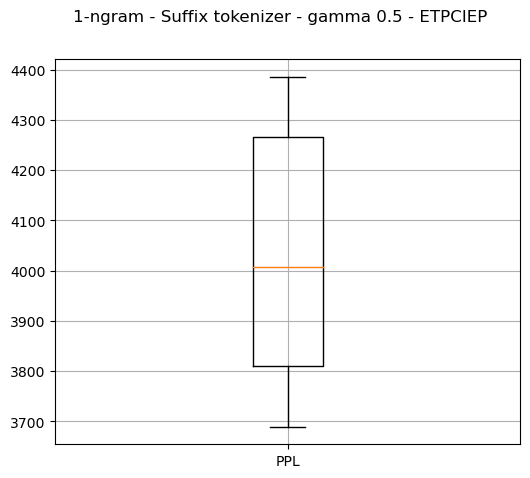

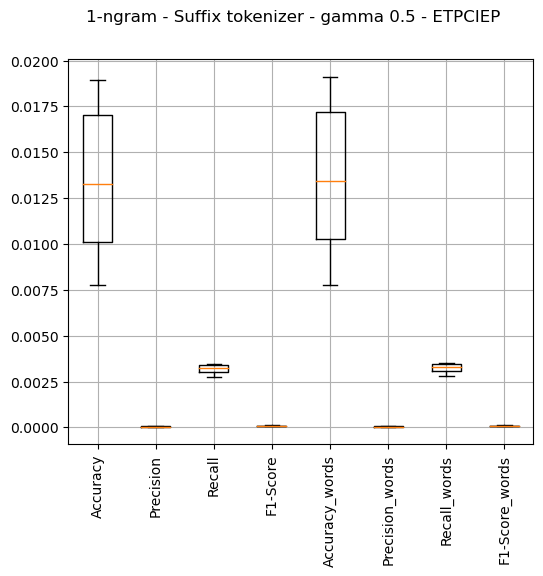

------------------------------------------------------------
1-ngram - Suffix tokenizer - gamma 1 - ETPCIEP 



100%|██████████| 10/10 [01:56<00:00, 11.68s/it]

Mean:
PPL                2523.382840
Accuracy              0.010026
Precision             0.000032
Recall                0.002894
F1-Score              0.000063
Accuracy_words        0.010107
Precision_words       0.000032
Recall_words          0.002937
F1-Score_words        0.000064
dtype: float64
Standar deviation:
PPL                149.714382
Accuracy             0.007266
Precision            0.000022
Recall               0.001040
F1-Score             0.000044
Accuracy_words       0.007325
Precision_words      0.000023
Recall_words         0.001055
F1-Score_words       0.000045
dtype: float64
Etruscan: uzinas
Prediction: uzinasth
Etruscan: alpnu
Prediction: alpnuth
Etruscan: --------e----------------------ndvmqv------------------
Prediction: --------e----------------------ndvmqv------------------th


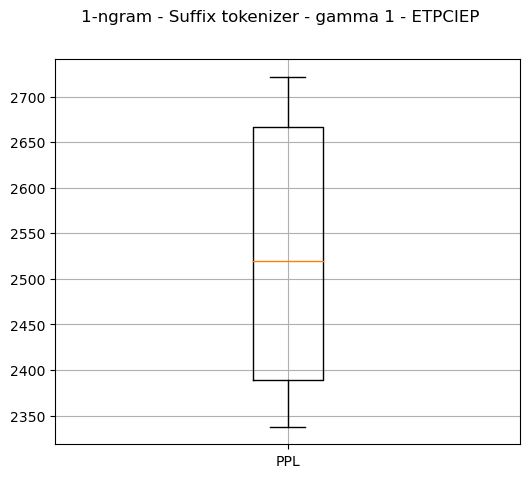

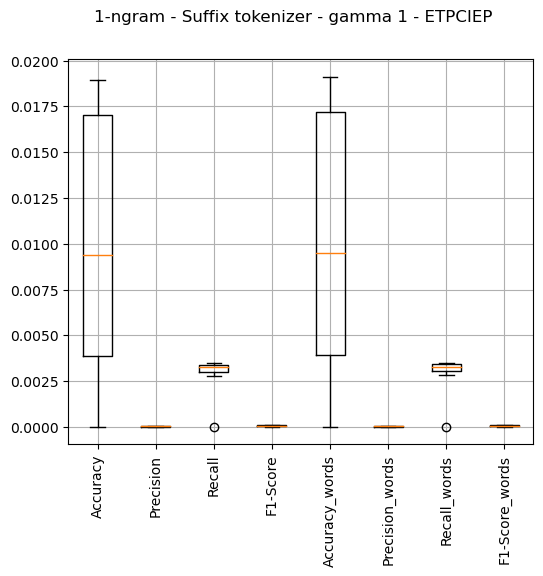

------------------------------------------------------------
2-ngram - Suffix tokenizer - gamma 0.1 - ETPCIEP 



100%|██████████| 10/10 [00:24<00:00,  2.42s/it]

Mean:
PPL                1683.356422
Accuracy              0.161913
Precision             0.045441
Recall                0.035229
F1-Score              0.031283
Accuracy_words        0.163475
Precision_words       0.046078
Recall_words          0.035666
F1-Score_words        0.031696
dtype: float64
Standar deviation:
PPL                85.919563
Accuracy            0.013516
Precision           0.009438
Recall              0.006811
F1-Score            0.007047
Accuracy_words      0.013489
Precision_words     0.009466
Recall_words        0.006799
F1-Score_words      0.007075
dtype: float64
Etruscan: uzinas
Prediction: uzinas larthial
Etruscan: alpnu
Prediction: alpnu nth
Etruscan: --------e----------------------ndvmqv------------------
Prediction: --------e----------------------ndvmqv------------------s


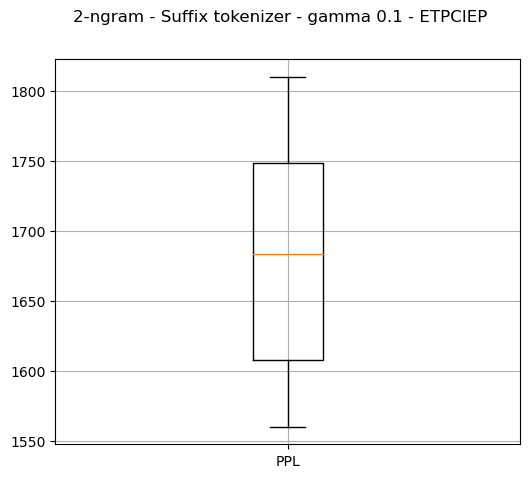

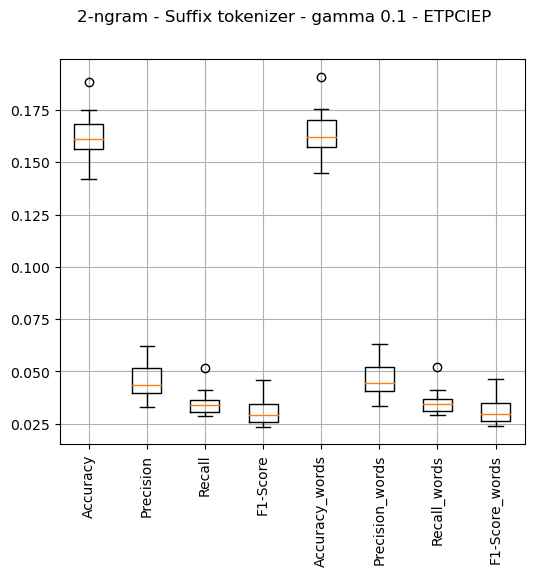

------------------------------------------------------------
2-ngram - Suffix tokenizer - gamma 0.5 - ETPCIEP 



100%|██████████| 10/10 [00:22<00:00,  2.26s/it]

Mean:
PPL                1202.256713
Accuracy              0.160230
Precision             0.045586
Recall                0.036515
F1-Score              0.031717
Accuracy_words        0.161776
Precision_words       0.046240
Recall_words          0.036980
F1-Score_words        0.032152
dtype: float64
Standar deviation:
PPL                44.528992
Accuracy            0.013841
Precision           0.010300
Recall              0.009455
F1-Score            0.007636
Accuracy_words      0.013798
Precision_words     0.010331
Recall_words        0.009496
F1-Score_words      0.007687
dtype: float64
Etruscan: uzinas
Prediction: uzinas pup
Etruscan: alpnu
Prediction: alpnu purh
Etruscan: --------e----------------------ndvmqv------------------
Prediction: --------e----------------------ndvmqv------------------s


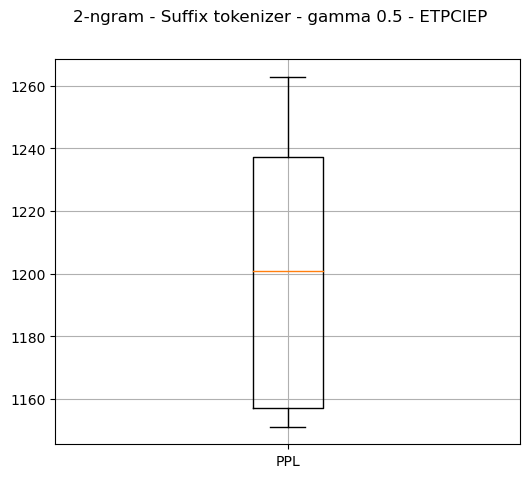

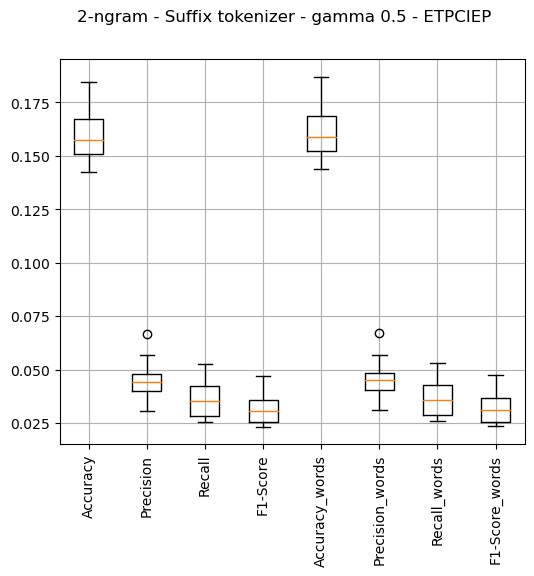

------------------------------------------------------------
2-ngram - Suffix tokenizer - gamma 1 - ETPCIEP 



100%|██████████| 10/10 [00:30<00:00,  3.03s/it]

Mean:
PPL                1186.578115
Accuracy              0.140996
Precision             0.046316
Recall                0.035245
F1-Score              0.031425
Accuracy_words        0.142351
Precision_words       0.046937
Recall_words          0.035678
F1-Score_words        0.031833
dtype: float64
Standar deviation:
PPL                35.652846
Accuracy            0.014032
Precision           0.011066
Recall              0.008383
F1-Score            0.008008
Accuracy_words      0.013994
Precision_words     0.011097
Recall_words        0.008368
F1-Score_words      0.008038
dtype: float64
Etruscan: uzinas
Prediction: uzinas rakh
Etruscan: alpnu
Prediction: alpnu rauf
Etruscan: --------e----------------------ndvmqv------------------
Prediction: --------e----------------------ndvmqv------------------sa


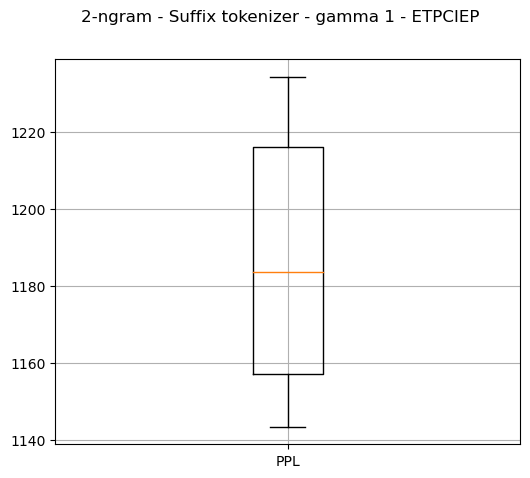

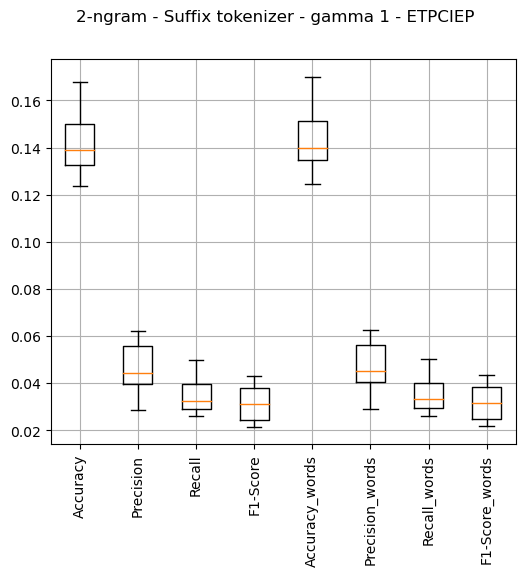

------------------------------------------------------------
3-ngram - Suffix tokenizer - gamma 0.1 - ETPCIEP 



100%|██████████| 10/10 [00:27<00:00,  2.76s/it]

Mean:
PPL                1422.788730
Accuracy              0.251595
Precision             0.110241
Recall                0.106172
F1-Score              0.098607
Accuracy_words        0.253508
Precision_words       0.110744
Recall_words          0.106075
F1-Score_words        0.098711
dtype: float64
Standar deviation:
PPL                55.427490
Accuracy            0.022958
Precision           0.022658
Recall              0.024177
F1-Score            0.021063
Accuracy_words      0.022629
Precision_words     0.022072
Recall_words        0.023716
F1-Score_words      0.020397
dtype: float64
Etruscan: uzinas
Prediction: uzinas larth
Etruscan: alpnu
Prediction: alpnu
Etruscan: --------e----------------------ndvmqv------------------
Prediction: --------e----------------------ndvmqv------------------ proro


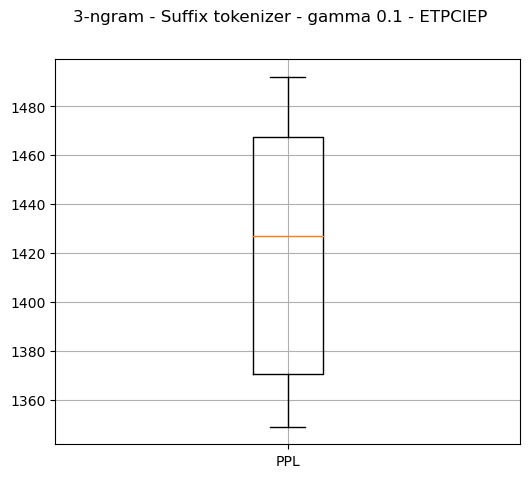

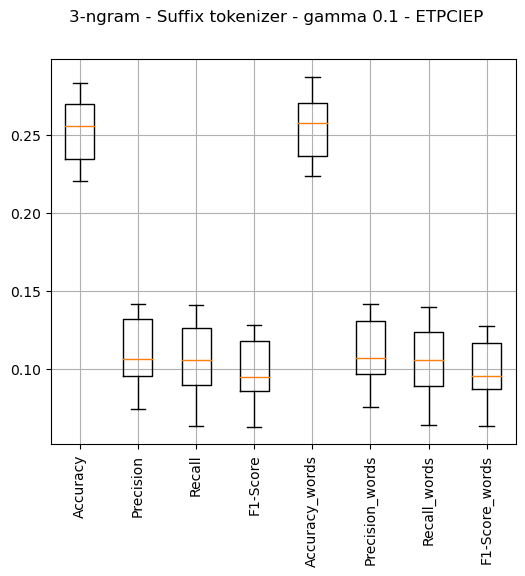

------------------------------------------------------------
3-ngram - Suffix tokenizer - gamma 0.5 - ETPCIEP 



100%|██████████| 10/10 [00:30<00:00,  3.07s/it]

Mean:
PPL                1326.720518
Accuracy              0.252608
Precision             0.109973
Recall                0.106590
F1-Score              0.097631
Accuracy_words        0.254522
Precision_words       0.110536
Recall_words          0.106527
F1-Score_words        0.097761
dtype: float64
Standar deviation:
PPL                34.033079
Accuracy            0.023159
Precision           0.022024
Recall              0.024128
F1-Score            0.020679
Accuracy_words      0.022757
Precision_words     0.021361
Recall_words        0.023745
F1-Score_words      0.019988
dtype: float64
Etruscan: uzinas
Prediction: uzinas larth
Etruscan: alpnu
Prediction: alpnu
Etruscan: --------e----------------------ndvmqv------------------
Prediction: --------e----------------------ndvmqv------------------r


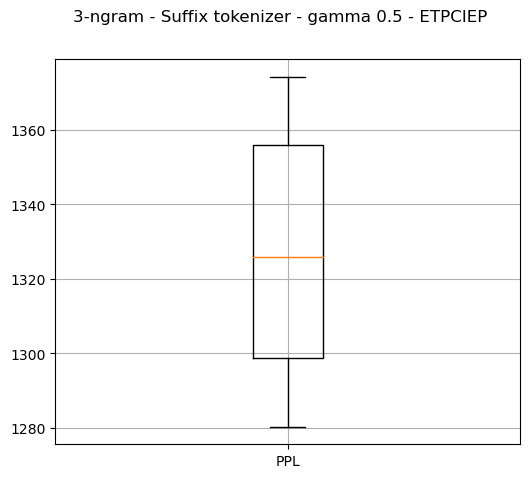

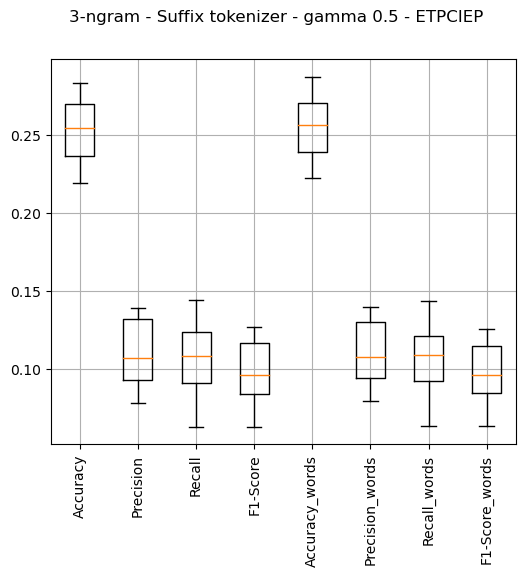

------------------------------------------------------------
3-ngram - Suffix tokenizer - gamma 1 - ETPCIEP 



100%|██████████| 10/10 [00:25<00:00,  2.59s/it]

Mean:
PPL                1404.344026
Accuracy              0.248329
Precision             0.109569
Recall                0.104148
F1-Score              0.096963
Accuracy_words        0.250208
Precision_words       0.110119
Recall_words          0.104058
F1-Score_words        0.097080
dtype: float64
Standar deviation:
PPL                28.852154
Accuracy            0.024001
Precision           0.022101
Recall              0.024741
F1-Score            0.021355
Accuracy_words      0.023735
Precision_words     0.021465
Recall_words        0.024428
F1-Score_words      0.020701
dtype: float64
Etruscan: uzinas
Prediction: uzinas lautn
Etruscan: alpnu
Prediction: alpnu
Etruscan: --------e----------------------ndvmqv------------------
Prediction: --------e----------------------ndvmqv------------------ razur


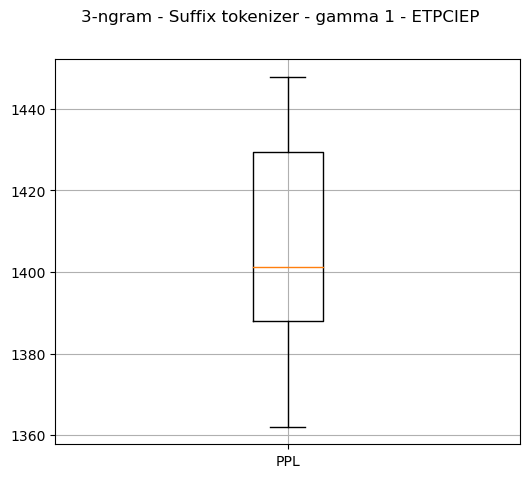

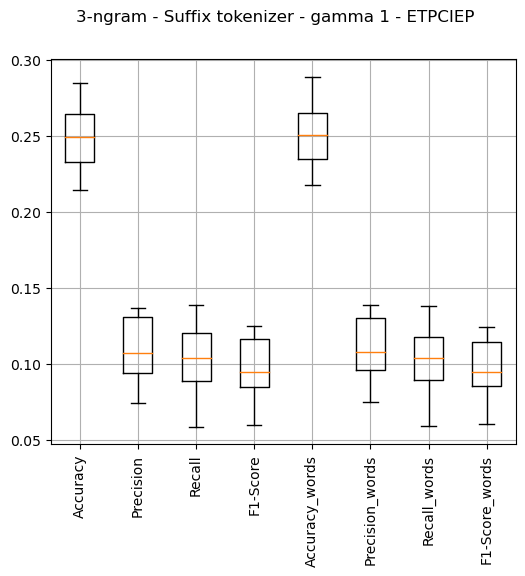

In [18]:
tokenizer = Data.SuffixTokenizer()
output = "{}-ngram - Suffix tokenizer - gamma {} - ETPCIEP"

do_job(order, gamma, ett, tokenizer, output)

### ETP

In [19]:
tokenizer = Data.SuffixTokenizer()
print_vocab_size(tokenizer, etp)

Estimate train voc. size: 4391
Estimate test voc. size: 1609
Voc. size: 6000


------------------------------------------------------------
1-ngram - Suffix tokenizer - gamma 0.1 - ETP 



100%|██████████| 10/10 [01:30<00:00,  9.03s/it]

Mean:
PPL                709.753322
Accuracy             0.014341
Precision            0.000059
Recall               0.004006
F1-Score             0.000117
Accuracy_words       0.014502
Precision_words      0.000061
Recall_words         0.004090
F1-Score_words       0.000121
dtype: float64
Standar deviation:
PPL                271.260342
Accuracy             0.005279
Precision            0.000027
Recall               0.000689
F1-Score             0.000053
Accuracy_words       0.005330
Precision_words      0.000028
Recall_words         0.000700
F1-Score_words       0.000055
dtype: float64
Etruscan: tite
Prediction: titethsicla
Etruscan: zathrumsne lushash fler hamphisca thezeri
Prediction: zathrumsne lushash flethsicla
Etruscan: --- mvkhza
Prediction: --- mvkhzathsicla


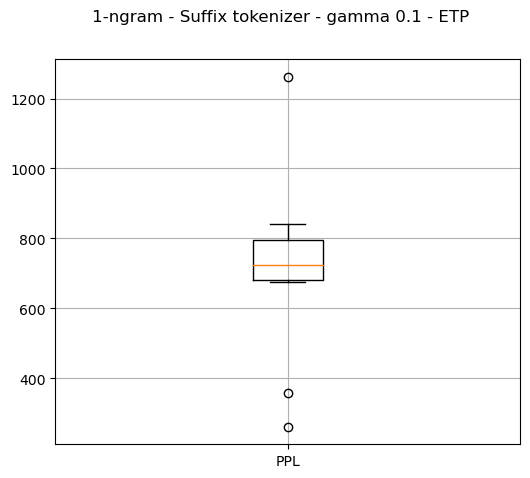

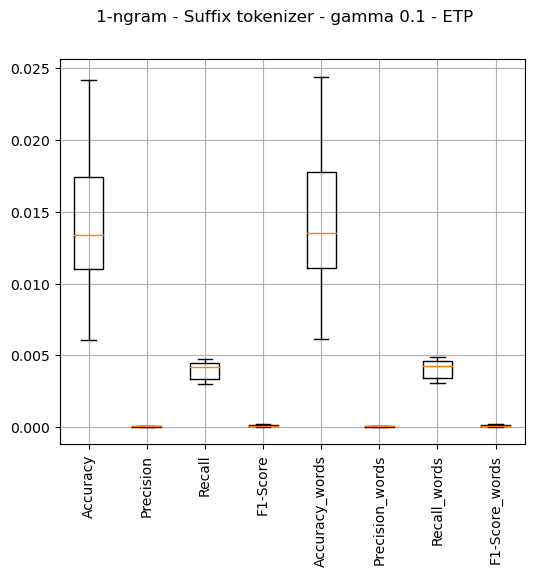

------------------------------------------------------------
1-ngram - Suffix tokenizer - gamma 0.5 - ETP 



100%|██████████| 10/10 [01:32<00:00,  9.23s/it]

Mean:
PPL                308.452828
Accuracy             0.007193
Precision            0.000031
Recall               0.003171
F1-Score             0.000062
Accuracy_words       0.007268
Precision_words      0.000032
Recall_words         0.003245
F1-Score_words       0.000063
dtype: float64
Standar deviation:
PPL                64.002540
Accuracy            0.009004
Precision           0.000040
Recall              0.001806
F1-Score            0.000078
Accuracy_words      0.009082
Precision_words     0.000041
Recall_words        0.001846
F1-Score_words      0.000080
dtype: float64
Etruscan: tite
Prediction: titethasi clen
Etruscan: zathrumsne lushash fler hamphisca thezeri
Prediction: zathrumsne lushash flethasi clen
Etruscan: --- mvkhza
Prediction: --- mvkhzathasi clen


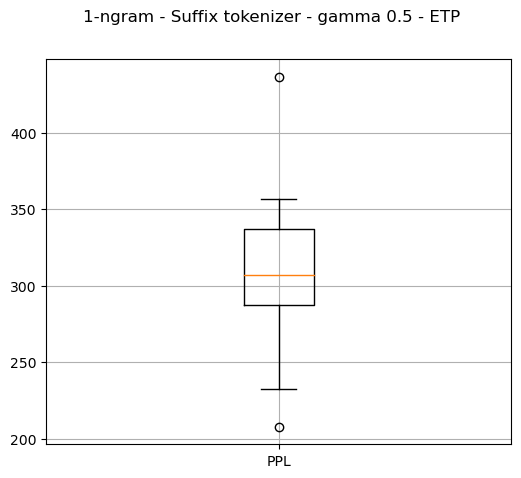

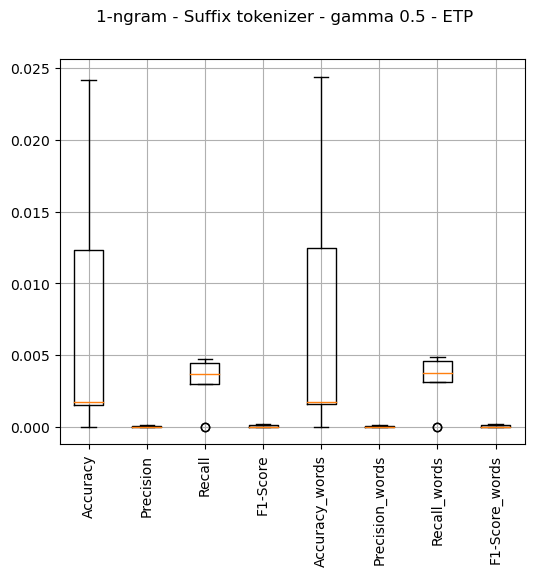

------------------------------------------------------------
1-ngram - Suffix tokenizer - gamma 1 - ETP 



100%|██████████| 10/10 [01:24<00:00,  8.47s/it]

Mean:
PPL                247.740224
Accuracy             0.000362
Precision            0.000001
Recall               0.001146
F1-Score             0.000003
Accuracy_words       0.000364
Precision_words      0.000001
Recall_words         0.001166
F1-Score_words       0.000003
dtype: float64
Standar deviation:
PPL                36.605499
Accuracy            0.000602
Precision           0.000002
Recall              0.001872
F1-Score            0.000005
Accuracy_words      0.000606
Precision_words     0.000003
Recall_words        0.001902
F1-Score_words      0.000005
dtype: float64
Etruscan: tite
Prediction: tite thalsai cra
Etruscan: zathrumsne lushash fler hamphisca thezeri
Prediction: zathrumsne lushash fle thalsai cra
Etruscan: --- mvkhza
Prediction: --- mvkhza thalsai cra


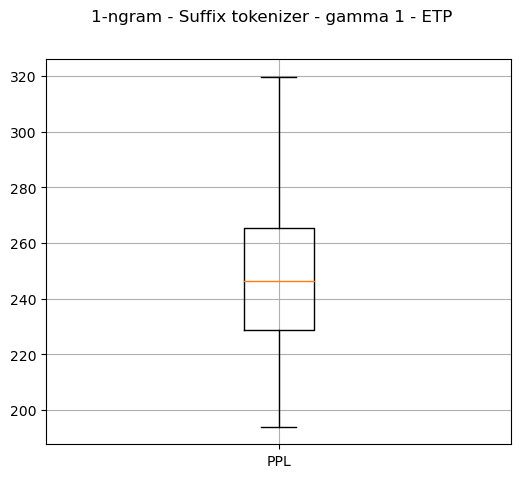

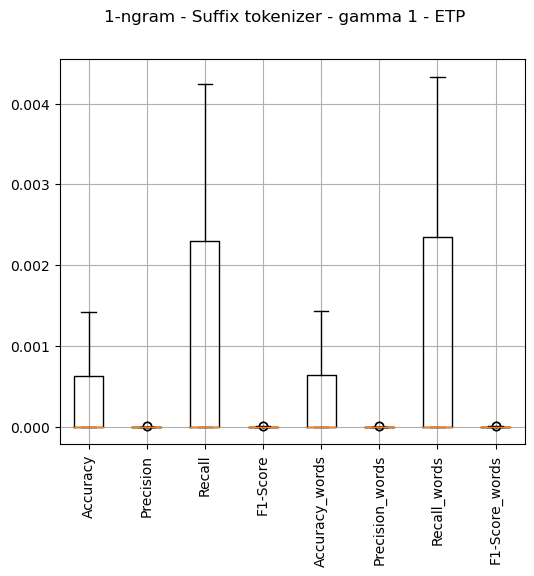

------------------------------------------------------------
2-ngram - Suffix tokenizer - gamma 0.1 - ETP 



100%|██████████| 10/10 [00:07<00:00,  1.34it/s]

Mean:
PPL                187.680930
Accuracy             0.131148
Precision            0.062189
Recall               0.044145
F1-Score             0.038594
Accuracy_words       0.132625
Precision_words      0.064099
Recall_words         0.044954
F1-Score_words       0.039530
dtype: float64
Standar deviation:
PPL                19.245598
Accuracy            0.022110
Precision           0.014935
Recall              0.015302
F1-Score            0.013726
Accuracy_words      0.022108
Precision_words     0.014972
Recall_words        0.015555
F1-Score_words      0.013967
dtype: float64
Etruscan: tite
Prediction: titeu p ercne
Etruscan: zathrumsne lushash fler hamphisca thezeri
Prediction: zathrumsne lushash fler matuna
Etruscan: --- mvkhza
Prediction: --- mvkhza hushur ash


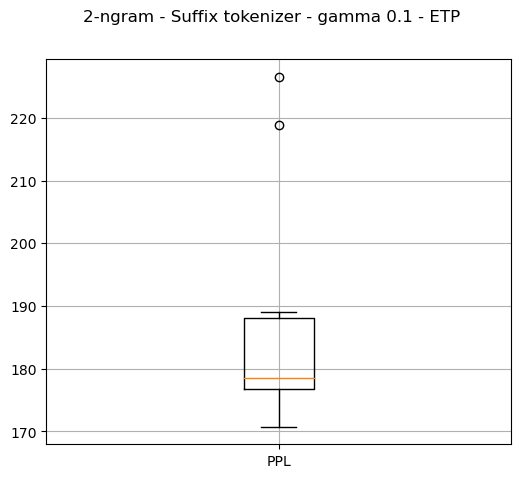

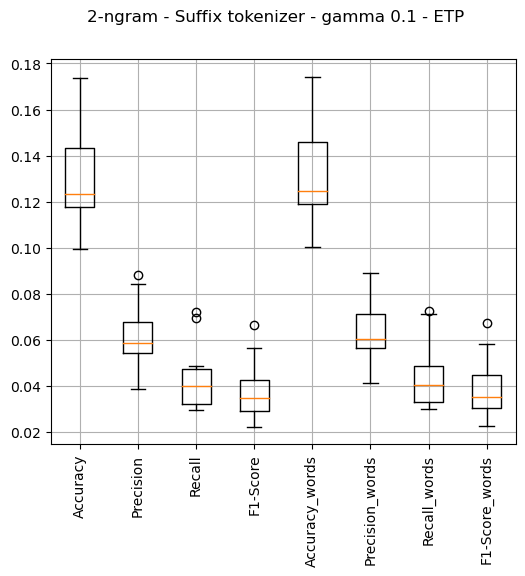

------------------------------------------------------------
2-ngram - Suffix tokenizer - gamma 0.5 - ETP 



100%|██████████| 10/10 [00:07<00:00,  1.41it/s]

Mean:
PPL                219.992550
Accuracy             0.125885
Precision            0.059517
Recall               0.041798
F1-Score             0.036062
Accuracy_words       0.127302
Precision_words      0.061380
Recall_words         0.042579
F1-Score_words       0.036955
dtype: float64
Standar deviation:
PPL                15.685957
Accuracy            0.018298
Precision           0.014453
Recall              0.013179
F1-Score            0.012197
Accuracy_words      0.018213
Precision_words     0.014576
Recall_words        0.013458
F1-Score_words      0.012474
dtype: float64
Etruscan: tite
Prediction: titeu p ercne
Etruscan: zathrumsne lushash fler hamphisca thezeri
Prediction: zathrumsne lushash fler menakhe
Etruscan: --- mvkhza
Prediction: --- mvkhza hushur av


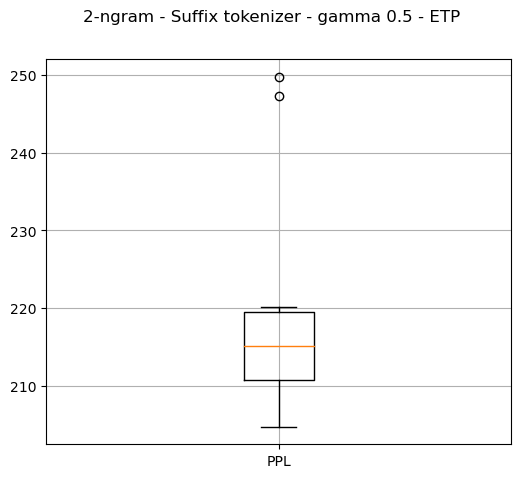

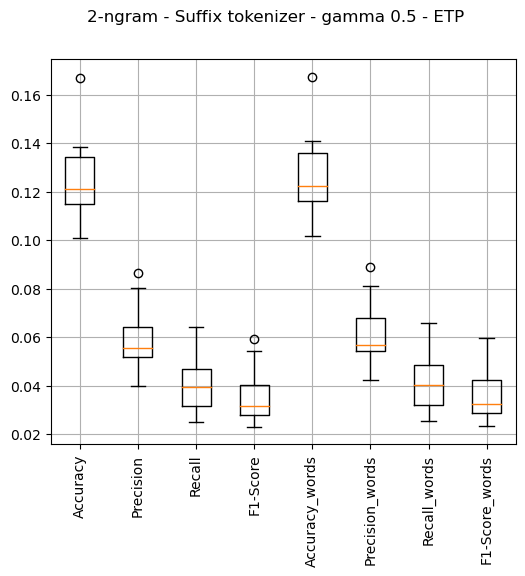

------------------------------------------------------------
2-ngram - Suffix tokenizer - gamma 1 - ETP 



100%|██████████| 10/10 [00:06<00:00,  1.46it/s]

Mean:
PPL                262.111508
Accuracy             0.124346
Precision            0.060863
Recall               0.042725
F1-Score             0.036807
Accuracy_words       0.125742
Precision_words      0.062498
Recall_words         0.043507
F1-Score_words       0.037559
dtype: float64
Standar deviation:
PPL                15.419205
Accuracy            0.018304
Precision           0.014380
Recall              0.012587
F1-Score            0.012465
Accuracy_words      0.018206
Precision_words     0.014259
Recall_words        0.012800
F1-Score_words      0.012625
dtype: float64
Etruscan: tite
Prediction: titeu qurtuniani
Etruscan: zathrumsne lushash fler hamphisca thezeri
Prediction: zathrumsne lushash fler menakhe
Etruscan: --- mvkhza
Prediction: --- mvkhza hushurc


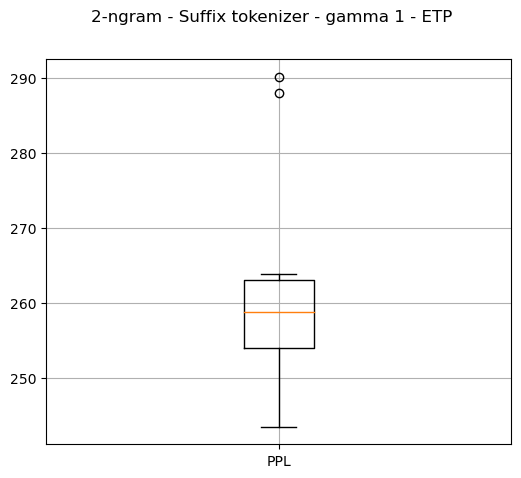

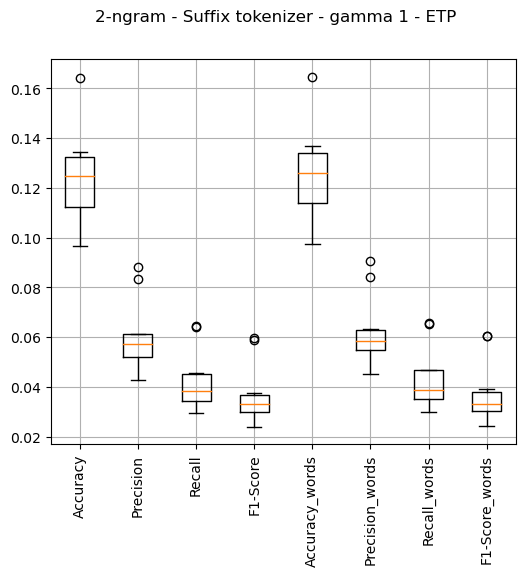

------------------------------------------------------------
3-ngram - Suffix tokenizer - gamma 0.1 - ETP 



100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

Mean:
PPL                243.271236
Accuracy             0.253469
Precision            0.144749
Recall               0.140338
F1-Score             0.128173
Accuracy_words       0.255767
Precision_words      0.146786
Recall_words         0.141166
F1-Score_words       0.129454
dtype: float64
Standar deviation:
PPL                23.252744
Accuracy            0.045900
Precision           0.036438
Recall              0.034738
F1-Score            0.034811
Accuracy_words      0.045441
Precision_words     0.035763
Recall_words        0.034261
F1-Score_words      0.034252
dtype: float64
Etruscan: tite
Prediction: tite utaves
Etruscan: zathrumsne lushash fler hamphisca thezeri
Prediction: zathrumsne lushash fler hamphi
Etruscan: --- mvkhza
Prediction: --- mvkhza hushur


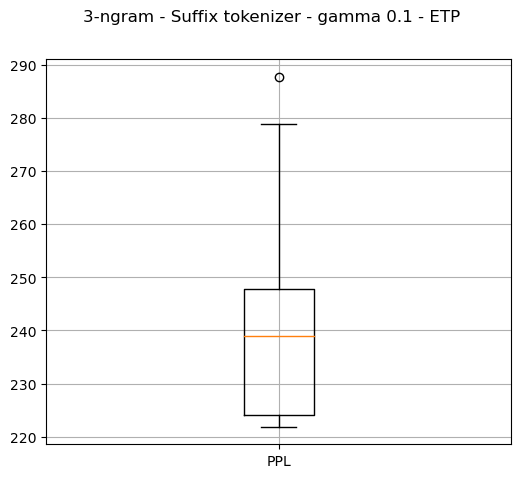

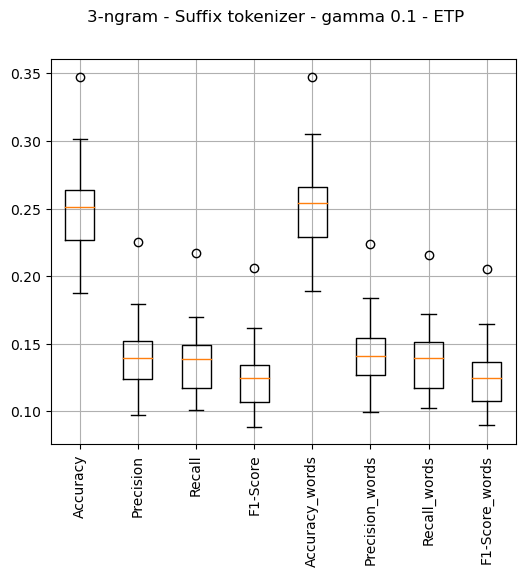

------------------------------------------------------------
3-ngram - Suffix tokenizer - gamma 0.5 - ETP 



100%|██████████| 10/10 [00:06<00:00,  1.44it/s]

Mean:
PPL                319.393391
Accuracy             0.251213
Precision            0.146027
Recall               0.140446
F1-Score             0.129312
Accuracy_words       0.253485
Precision_words      0.148051
Recall_words         0.141247
F1-Score_words       0.130585
dtype: float64
Standar deviation:
PPL                21.752088
Accuracy            0.044961
Precision           0.036539
Recall              0.034046
F1-Score            0.034643
Accuracy_words      0.044473
Precision_words     0.035869
Recall_words        0.033588
F1-Score_words      0.034064
dtype: float64
Etruscan: tite
Prediction: tite utaves
Etruscan: zathrumsne lushash fler hamphisca thezeri
Prediction: zathrumsne lushash fler hamphi
Etruscan: --- mvkhza
Prediction: --- mvkhza hushur


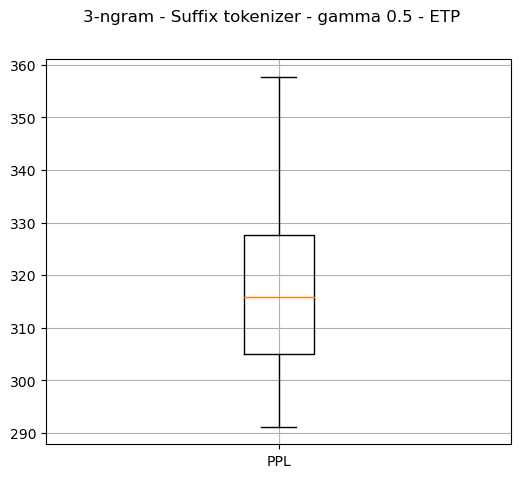

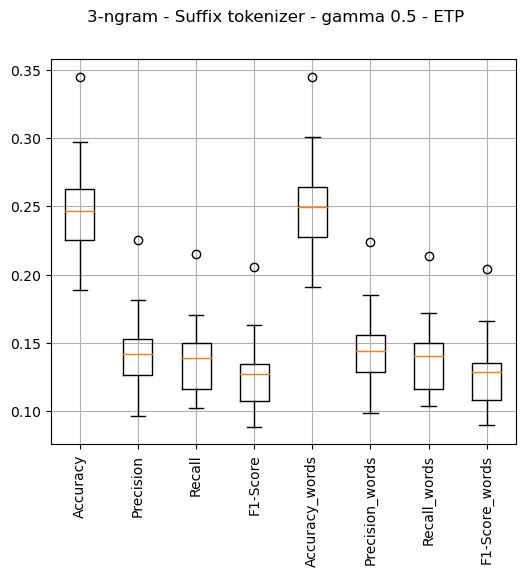

------------------------------------------------------------
3-ngram - Suffix tokenizer - gamma 1 - ETP 



100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

Mean:
PPL                374.576558
Accuracy             0.249772
Precision            0.145968
Recall               0.140354
F1-Score             0.129055
Accuracy_words       0.252028
Precision_words      0.147950
Recall_words         0.141149
F1-Score_words       0.130301
dtype: float64
Standar deviation:
PPL                21.536545
Accuracy            0.044937
Precision           0.035542
Recall              0.033099
F1-Score            0.034001
Accuracy_words      0.044444
Precision_words     0.034878
Recall_words        0.032620
F1-Score_words      0.033395
dtype: float64
Etruscan: tite
Prediction: tite utaves
Etruscan: zathrumsne lushash fler hamphisca thezeri
Prediction: zathrumsne lushash fler hamphi
Etruscan: --- mvkhza
Prediction: --- mvkhza hushur


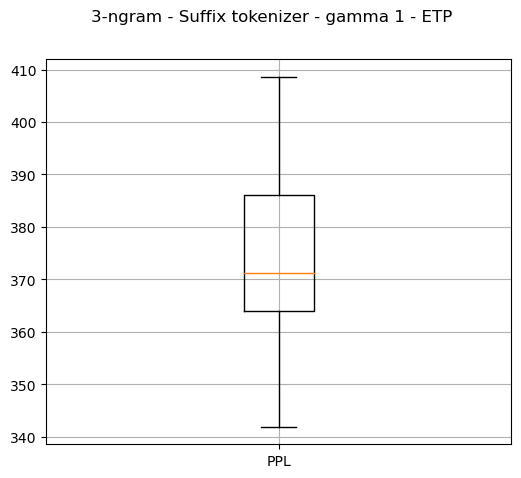

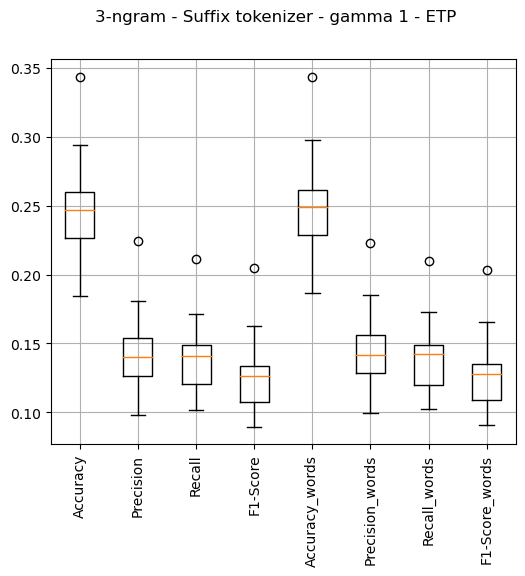

In [20]:
tokenizer = Data.SuffixTokenizer()
output = "{}-ngram - Suffix tokenizer - gamma {} - ETP"

do_job(order, gamma, etp, tokenizer, output)

## SentencePiece Tokenizer

### ETP+CIEP

In [21]:
from typing import List

class SentencePieceWrap(Data.SentencePieceTokenizer):
    def tokenize(self, x: str) -> List[int]:
        return self._sp_words.encode_as_pieces(x, add_bos=False, add_eos=False)
    
    def detokenize(self, x: List[int]) -> str:
        return self._sp_words.decode(x)

In [22]:
tokenizer = SentencePieceWrap(Data.ETRUSCAN)
tokenizer.load("../Data/all_small")
print_vocab_size(tokenizer, ett)

Estimate train voc. size: 38323
Estimate test voc. size: 9262
Voc. size: 47585


------------------------------------------------------------
1-ngram - Suffix tokenizer - gamma 0.1 - ETPCIEP 



  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:54<00:00, 11.50s/it]

Mean:
PPL                131.535471
Accuracy             0.154090
Precision            0.000333
Recall               0.002164
F1-Score             0.000578
Accuracy_words       0.000000
Precision_words      0.000000
Recall_words         0.000000
F1-Score_words       0.000000
dtype: float64
Standar deviation:
PPL                5.360665
Accuracy           0.007700
Precision          0.000020
Recall             0.000070
F1-Score           0.000031
Accuracy_words     0.000000
Precision_words    0.000000
Recall_words       0.000000
F1-Score_words     0.000000
dtype: float64
Etruscan: uzinas
Prediction: uzinas 
Etruscan: alpnu
Prediction: alpnu 
Etruscan: --------e----------------------ndvmqv------------------
Prediction: --------e---------------------- 


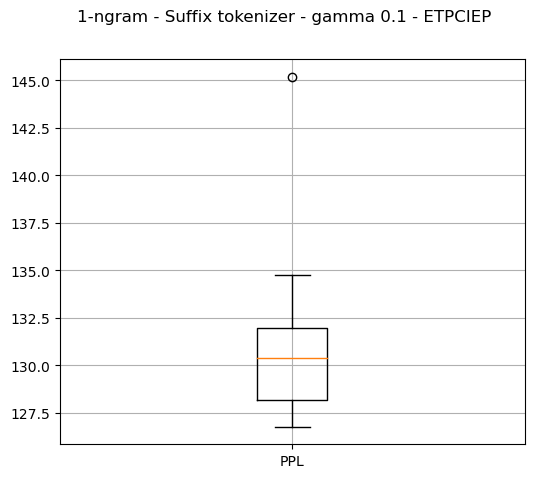

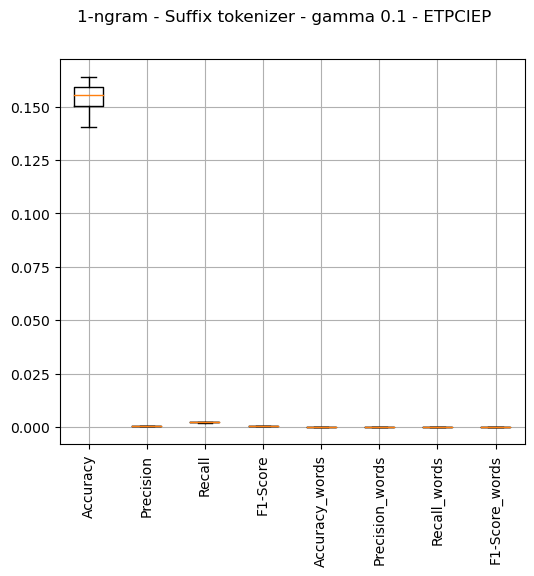

------------------------------------------------------------
1-ngram - Suffix tokenizer - gamma 0.5 - ETPCIEP 



100%|██████████| 10/10 [01:54<00:00, 11.46s/it]

Mean:
PPL                121.016726
Accuracy             0.154090
Precision            0.000333
Recall               0.002164
F1-Score             0.000578
Accuracy_words       0.000000
Precision_words      0.000000
Recall_words         0.000000
F1-Score_words       0.000000
dtype: float64
Standar deviation:
PPL                3.941079
Accuracy           0.007700
Precision          0.000020
Recall             0.000070
F1-Score           0.000031
Accuracy_words     0.000000
Precision_words    0.000000
Recall_words       0.000000
F1-Score_words     0.000000
dtype: float64
Etruscan: uzinas
Prediction: uzinas 
Etruscan: alpnu
Prediction: alpnu 
Etruscan: --------e----------------------ndvmqv------------------
Prediction: --------e---------------------- 


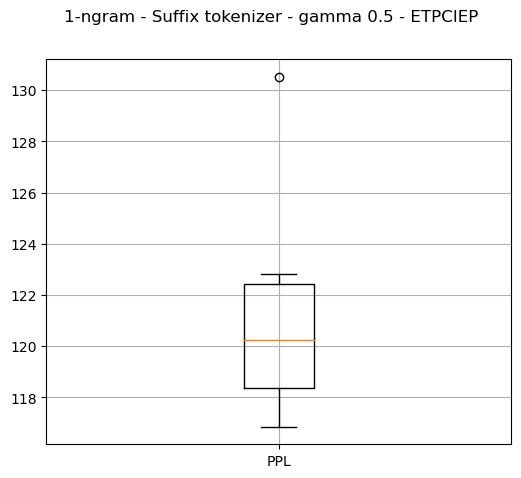

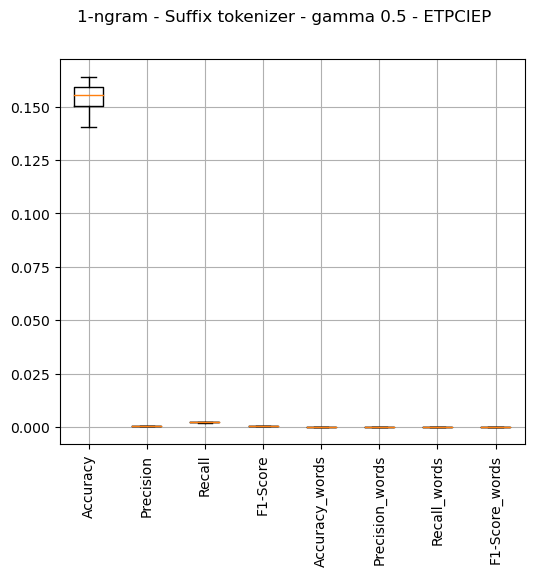

------------------------------------------------------------
1-ngram - Suffix tokenizer - gamma 1 - ETPCIEP 



100%|██████████| 10/10 [01:49<00:00, 10.96s/it]

Mean:
PPL                117.095467
Accuracy             0.154090
Precision            0.000333
Recall               0.002164
F1-Score             0.000578
Accuracy_words       0.000000
Precision_words      0.000000
Recall_words         0.000000
F1-Score_words       0.000000
dtype: float64
Standar deviation:
PPL                3.604265
Accuracy           0.007700
Precision          0.000020
Recall             0.000070
F1-Score           0.000031
Accuracy_words     0.000000
Precision_words    0.000000
Recall_words       0.000000
F1-Score_words     0.000000
dtype: float64
Etruscan: uzinas
Prediction: uzinas 
Etruscan: alpnu
Prediction: alpnu 
Etruscan: --------e----------------------ndvmqv------------------
Prediction: --------e---------------------- 


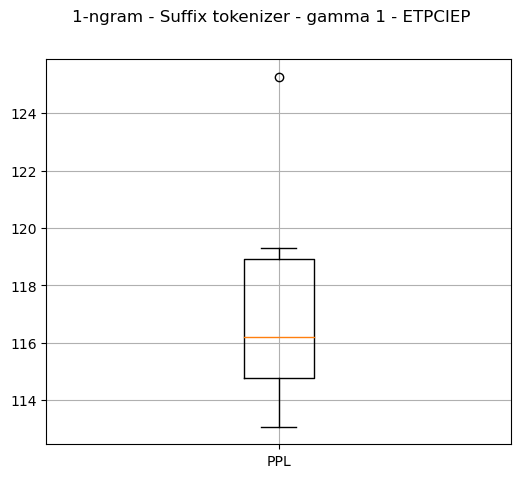

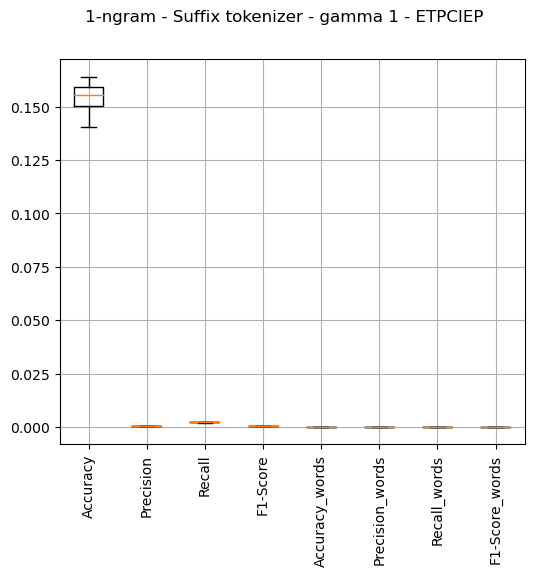

------------------------------------------------------------
2-ngram - Suffix tokenizer - gamma 0.1 - ETPCIEP 



100%|██████████| 10/10 [00:42<00:00,  4.21s/it]

Mean:
PPL                52.814177
Accuracy            0.085568
Precision           0.026231
Recall              0.028173
F1-Score            0.018870
Accuracy_words      0.038656
Precision_words     0.027958
Recall_words        0.028119
F1-Score_words      0.019453
dtype: float64
Standar deviation:
PPL                1.891811
Accuracy           0.008604
Precision          0.003507
Recall             0.005923
F1-Score           0.003260
Accuracy_words     0.002784
Precision_words    0.004033
Recall_words       0.006114
F1-Score_words     0.003617
dtype: float64
Etruscan: uzinas
Prediction: uzinasvi
Etruscan: alpnu
Prediction: alpnuthan
Etruscan: --------e----------------------ndvmqv------------------
Prediction: --------e----------------------th


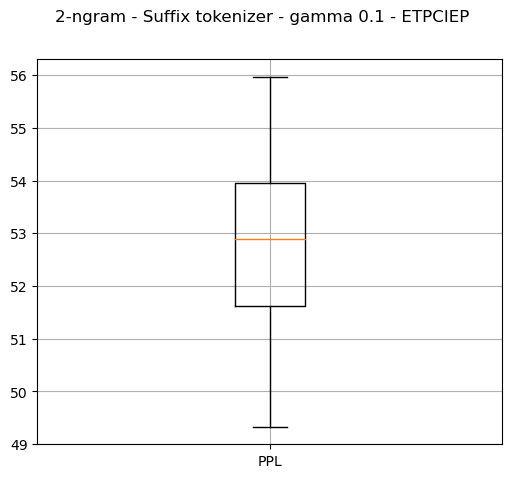

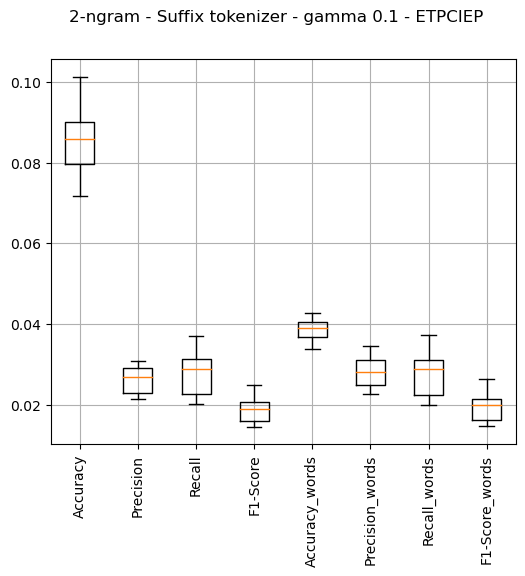

------------------------------------------------------------
2-ngram - Suffix tokenizer - gamma 0.5 - ETPCIEP 



100%|██████████| 10/10 [00:43<00:00,  4.33s/it]

Mean:
PPL                65.134996
Accuracy            0.073659
Precision           0.026113
Recall              0.028133
F1-Score            0.018528
Accuracy_words      0.037008
Precision_words     0.027704
Recall_words        0.028187
F1-Score_words      0.019163
dtype: float64
Standar deviation:
PPL                1.723379
Accuracy           0.010110
Precision          0.003296
Recall             0.004991
F1-Score           0.002816
Accuracy_words     0.002296
Precision_words    0.003402
Recall_words       0.005162
F1-Score_words     0.003081
dtype: float64
Etruscan: uzinas
Prediction: uzinasuv
Etruscan: alpnu
Prediction: alpnuthe
Etruscan: --------e----------------------ndvmqv------------------
Prediction: --------e----------------------th


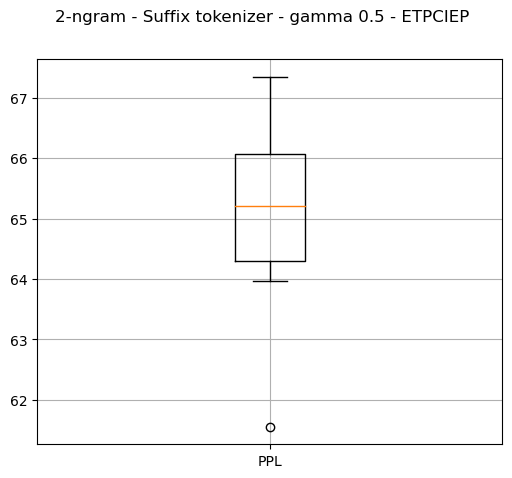

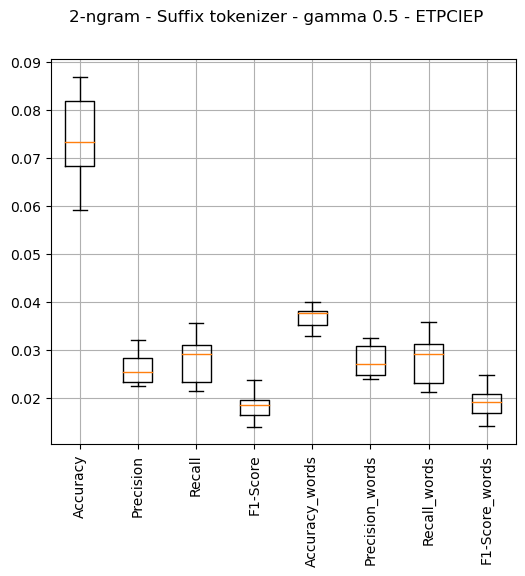

------------------------------------------------------------
2-ngram - Suffix tokenizer - gamma 1 - ETPCIEP 



100%|██████████| 10/10 [00:59<00:00,  5.97s/it]

Mean:
PPL                76.413936
Accuracy            0.062107
Precision           0.026334
Recall              0.027814
F1-Score            0.018573
Accuracy_words      0.036167
Precision_words     0.027716
Recall_words        0.028009
F1-Score_words      0.019293
dtype: float64
Standar deviation:
PPL                1.823427
Accuracy           0.005767
Precision          0.003672
Recall             0.005085
F1-Score           0.003353
Accuracy_words     0.002751
Precision_words    0.004226
Recall_words       0.005257
F1-Score_words     0.003614
dtype: float64
Etruscan: uzinas
Prediction: uzinasut
Etruscan: alpnu
Prediction: alpnuthe
Etruscan: --------e----------------------ndvmqv------------------
Prediction: --------e----------------------th


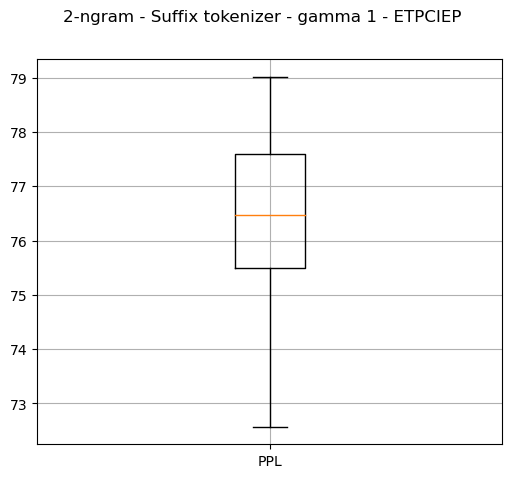

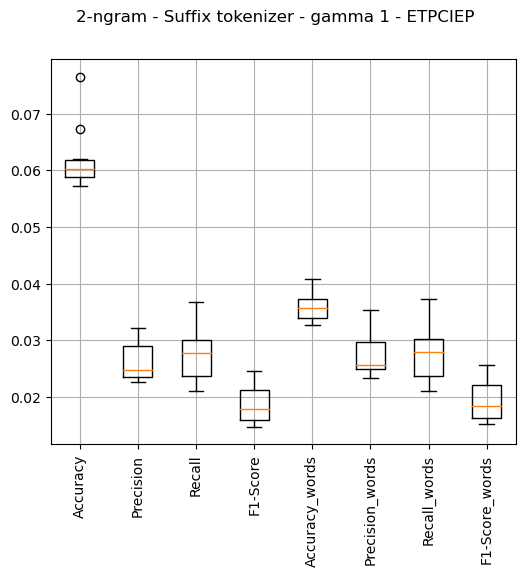

------------------------------------------------------------
3-ngram - Suffix tokenizer - gamma 0.1 - ETPCIEP 



100%|██████████| 10/10 [00:21<00:00,  2.20s/it]

Mean:
PPL                71.900730
Accuracy            0.203562
Precision           0.090492
Recall              0.080150
F1-Score            0.068494
Accuracy_words      0.148028
Precision_words     0.096435
Recall_words        0.080653
F1-Score_words      0.071358
dtype: float64
Standar deviation:
PPL                2.021086
Accuracy           0.004918
Precision          0.012097
Recall             0.009934
F1-Score           0.009162
Accuracy_words     0.004433
Precision_words    0.013319
Recall_words       0.010029
F1-Score_words     0.009778
dtype: float64
Etruscan: uzinas
Prediction: uzinas 
Etruscan: alpnu
Prediction: alpnu
Etruscan: --------e----------------------ndvmqv------------------
Prediction: --------e----------------------th


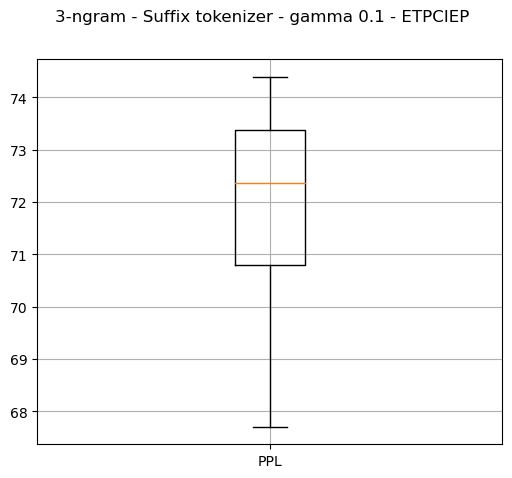

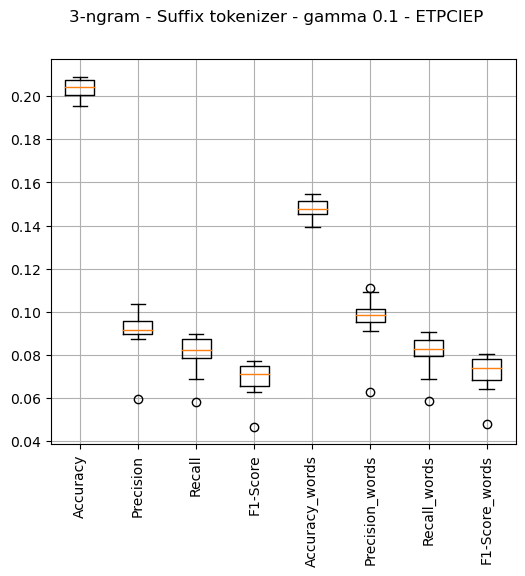

------------------------------------------------------------
3-ngram - Suffix tokenizer - gamma 0.5 - ETPCIEP 



100%|██████████| 10/10 [00:21<00:00,  2.13s/it]


Mean:
PPL                100.806600
Accuracy             0.197483
Precision            0.087605
Recall               0.079208
F1-Score             0.066456
Accuracy_words       0.142554
Precision_words      0.093042
Recall_words         0.079671
F1-Score_words       0.069093
dtype: float64
Standar deviation:
PPL                2.425896
Accuracy           0.005647
Precision          0.010827
Recall             0.008649
F1-Score           0.008349
Accuracy_words     0.005179
Precision_words    0.012396
Recall_words       0.008765
F1-Score_words     0.008957
dtype: float64
Etruscan: uzinas
Prediction: uzinas 
Etruscan: alpnu
Prediction: alpnu
Etruscan: --------e----------------------ndvmqv------------------
Prediction: --------e----------------------th


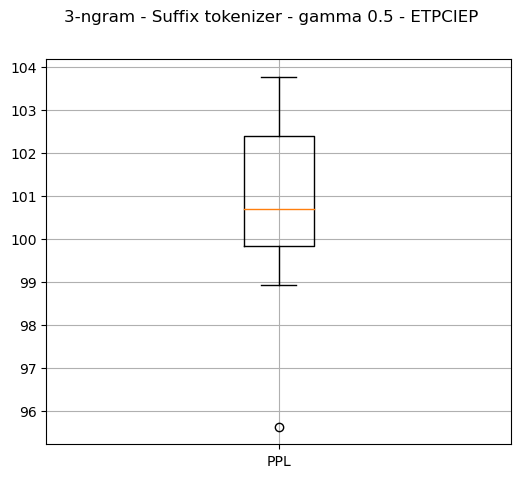

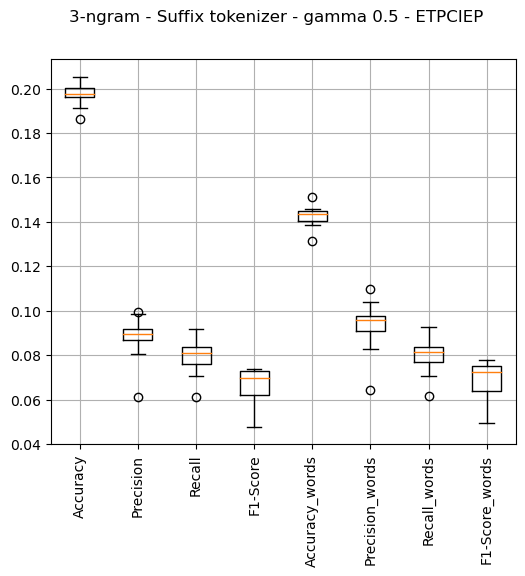

------------------------------------------------------------
3-ngram - Suffix tokenizer - gamma 1 - ETPCIEP 



100%|██████████| 10/10 [00:23<00:00,  2.31s/it]

Mean:
PPL                121.983739
Accuracy             0.191493
Precision            0.087614
Recall               0.078898
F1-Score             0.065786
Accuracy_words       0.140334
Precision_words      0.092732
Recall_words         0.079409
F1-Score_words       0.068314
dtype: float64
Standar deviation:
PPL                2.745319
Accuracy           0.006155
Precision          0.011668
Recall             0.008877
F1-Score           0.008499
Accuracy_words     0.005409
Precision_words    0.013101
Recall_words       0.008988
F1-Score_words     0.009047
dtype: float64
Etruscan: uzinas
Prediction: uzinas 
Etruscan: alpnu
Prediction: alpnu
Etruscan: --------e----------------------ndvmqv------------------
Prediction: --------e----------------------th


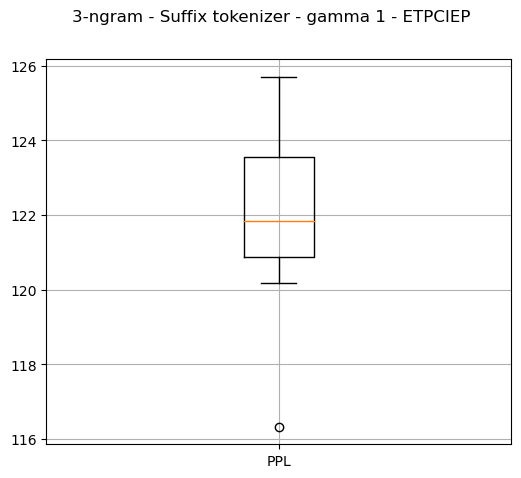

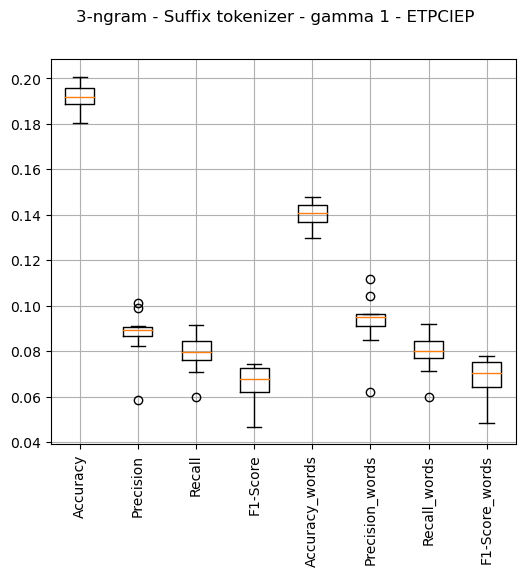

In [23]:
output = "{}-ngram - SP tokenizer - gamma {} - ETPCIEP"

do_job(order, gamma, ett, tokenizer, output)

### ETP

In [24]:
print_vocab_size(tokenizer, etp)

Estimate train voc. size: 7215
Estimate test voc. size: 2668
Voc. size: 9883


------------------------------------------------------------
1-ngram - Suffix tokenizer - gamma 0.1 - ETP 



  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [04:38<00:00, 27.87s/it]

Mean:
PPL                70.597072
Accuracy            0.260581
Precision           0.001061
Recall              0.004065
F1-Score            0.001683
Accuracy_words      0.000000
Precision_words     0.000000
Recall_words        0.000000
F1-Score_words      0.000000
dtype: float64
Standar deviation:
PPL                7.253720
Accuracy           0.011245
Precision          0.000144
Recall             0.000435
F1-Score           0.000216
Accuracy_words     0.000000
Precision_words    0.000000
Recall_words       0.000000
F1-Score_words     0.000000
dtype: float64
Etruscan: tite
Prediction: tite  nhu
Etruscan: zathrumsne lushash fler hamphisca thezeri
Prediction: zathrum  nhu
Etruscan: --- mvkhza
Prediction: --- m  nhu


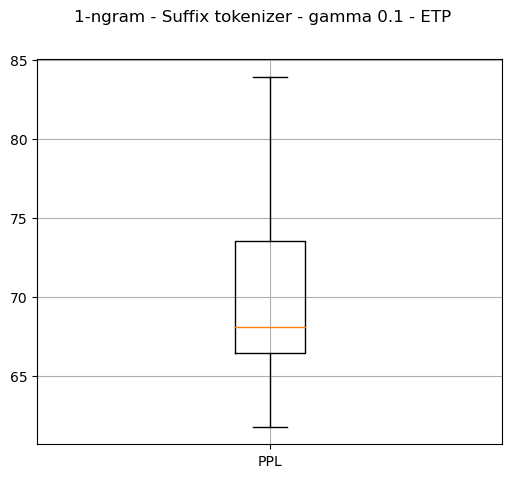

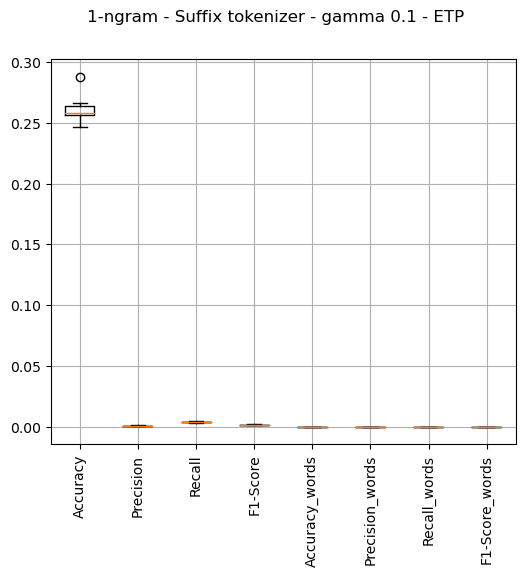

------------------------------------------------------------
1-ngram - Suffix tokenizer - gamma 0.5 - ETP 



100%|██████████| 10/10 [04:08<00:00, 24.85s/it]

Mean:
PPL                64.163994
Accuracy            0.260581
Precision           0.001061
Recall              0.004065
F1-Score            0.001683
Accuracy_words      0.000000
Precision_words     0.000000
Recall_words        0.000000
F1-Score_words      0.000000
dtype: float64
Standar deviation:
PPL                4.049722
Accuracy           0.011245
Precision          0.000144
Recall             0.000435
F1-Score           0.000216
Accuracy_words     0.000000
Precision_words    0.000000
Recall_words       0.000000
F1-Score_words     0.000000
dtype: float64
Etruscan: tite
Prediction: tite  munihu
Etruscan: zathrumsne lushash fler hamphisca thezeri
Prediction: zathrum  munihu
Etruscan: --- mvkhza
Prediction: --- m  munihu


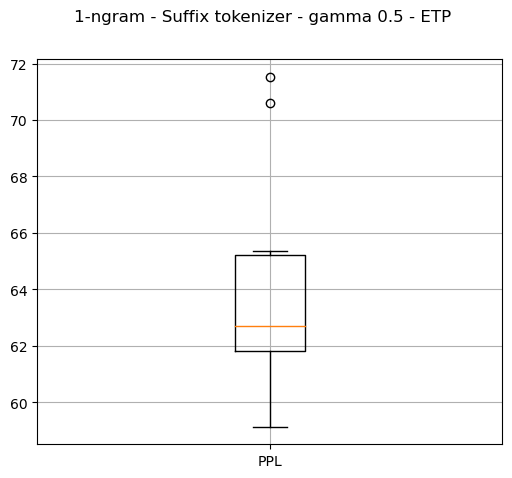

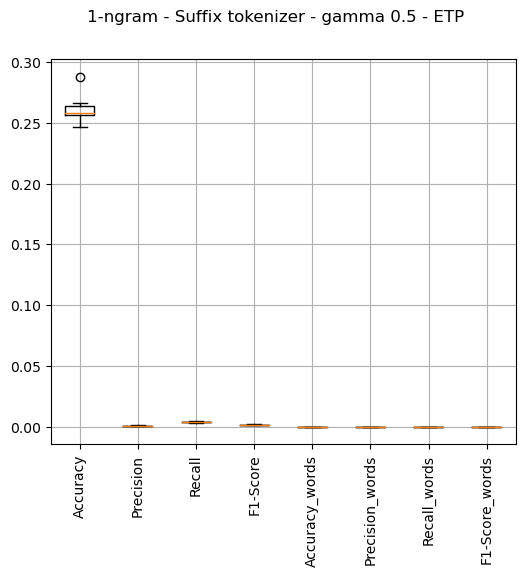

------------------------------------------------------------
1-ngram - Suffix tokenizer - gamma 1 - ETP 



100%|██████████| 10/10 [04:02<00:00, 24.25s/it]

Mean:
PPL                62.253332
Accuracy            0.260581
Precision           0.001061
Recall              0.004065
F1-Score            0.001683
Accuracy_words      0.000000
Precision_words     0.000000
Recall_words        0.000000
F1-Score_words      0.000000
dtype: float64
Standar deviation:
PPL                3.196395
Accuracy           0.011245
Precision          0.000144
Recall             0.000435
F1-Score           0.000216
Accuracy_words     0.000000
Precision_words    0.000000
Recall_words       0.000000
F1-Score_words     0.000000
dtype: float64
Etruscan: tite
Prediction: tite  muhnai
Etruscan: zathrumsne lushash fler hamphisca thezeri
Prediction: zathrum  muhnai
Etruscan: --- mvkhza
Prediction: --- m  muhnai


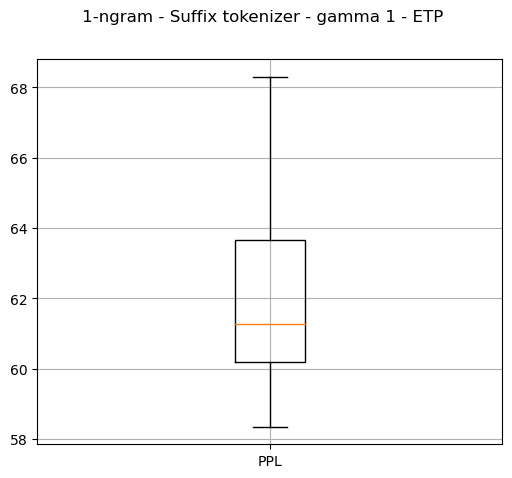

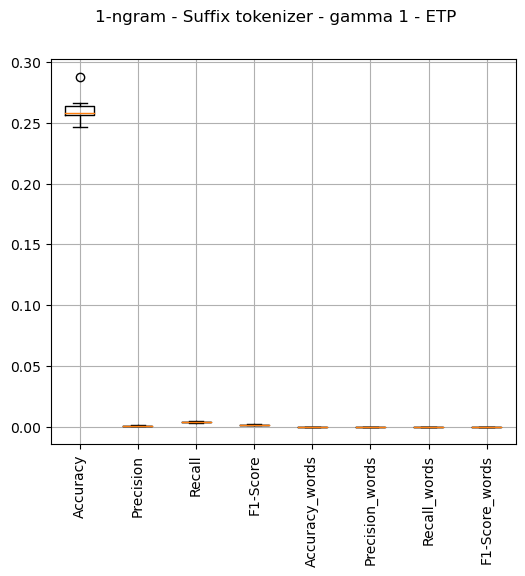

------------------------------------------------------------
2-ngram - Suffix tokenizer - gamma 0.1 - ETP 



100%|██████████| 10/10 [00:12<00:00,  1.21s/it]

Mean:
PPL                41.036774
Accuracy            0.270258
Precision           0.041742
Recall              0.032354
F1-Score            0.026482
Accuracy_words      0.039412
Precision_words     0.043169
Recall_words        0.029089
F1-Score_words      0.024827
dtype: float64
Standar deviation:
PPL                3.008066
Accuracy           0.010196
Precision          0.005097
Recall             0.004256
F1-Score           0.003423
Accuracy_words     0.006332
Precision_words    0.005516
Recall_words       0.004298
F1-Score_words     0.003583
dtype: float64
Etruscan: tite
Prediction: tite sinu 
Etruscan: zathrumsne lushash fler hamphisca thezeri
Prediction: zathrum sinu 
Etruscan: --- mvkhza
Prediction: --- m sinu 


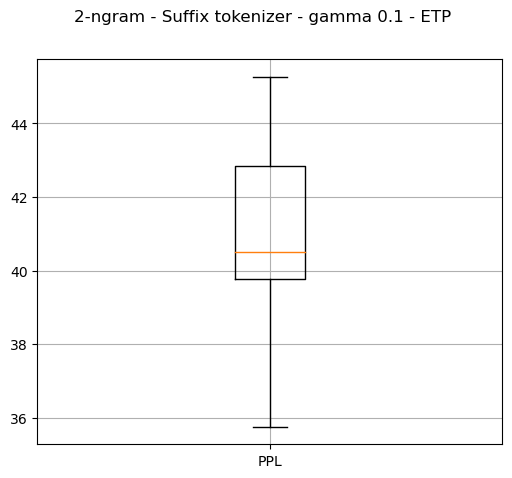

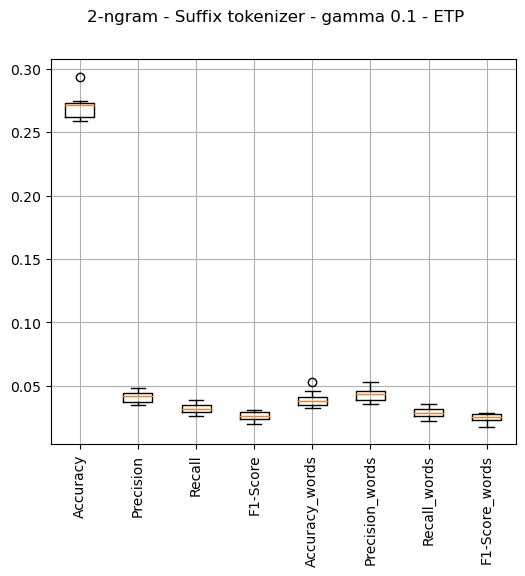

------------------------------------------------------------
2-ngram - Suffix tokenizer - gamma 0.5 - ETP 



100%|██████████| 10/10 [00:09<00:00,  1.05it/s]

Mean:
PPL                55.381813
Accuracy            0.267942
Precision           0.038450
Recall              0.030034
F1-Score            0.023760
Accuracy_words      0.037380
Precision_words     0.039392
Recall_words        0.026757
F1-Score_words      0.022014
dtype: float64
Standar deviation:
PPL                2.336806
Accuracy           0.009410
Precision          0.007059
Recall             0.004359
F1-Score           0.004369
Accuracy_words     0.007368
Precision_words    0.006876
Recall_words       0.004443
F1-Score_words     0.004510
dtype: float64
Etruscan: tite
Prediction: tite spitus
Etruscan: zathrumsne lushash fler hamphisca thezeri
Prediction: zathrum spitus
Etruscan: --- mvkhza
Prediction: --- m spitus


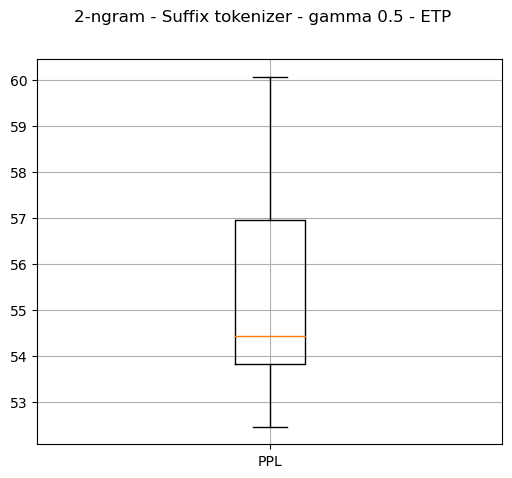

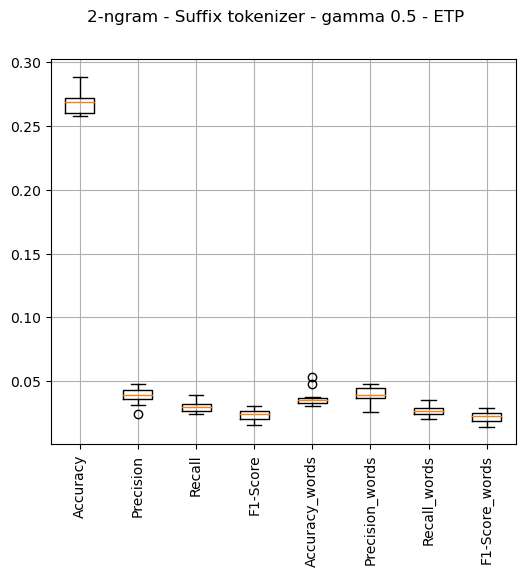

------------------------------------------------------------
2-ngram - Suffix tokenizer - gamma 1 - ETP 



100%|██████████| 10/10 [00:12<00:00,  1.22s/it]

Mean:
PPL                68.544749
Accuracy            0.265295
Precision           0.037484
Recall              0.030226
F1-Score            0.023511
Accuracy_words      0.037198
Precision_words     0.038545
Recall_words        0.026999
F1-Score_words      0.021811
dtype: float64
Standar deviation:
PPL                2.167894
Accuracy           0.009656
Precision          0.005937
Recall             0.004331
F1-Score           0.003881
Accuracy_words     0.007221
Precision_words    0.005838
Recall_words       0.004388
F1-Score_words     0.003966
dtype: float64
Etruscan: tite
Prediction: tite spitus
Etruscan: zathrumsne lushash fler hamphisca thezeri
Prediction: zathrum spitus
Etruscan: --- mvkhza
Prediction: --- m spitus


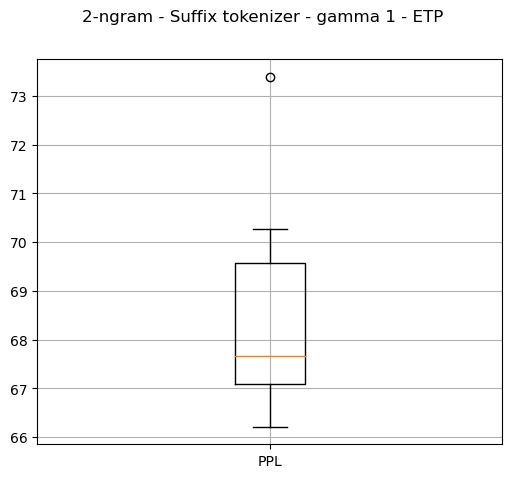

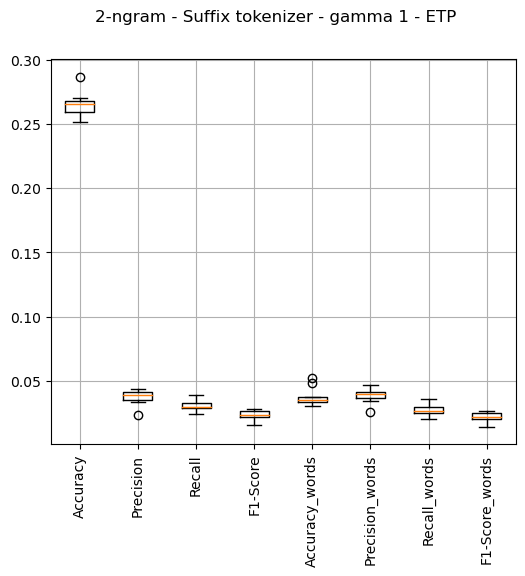

------------------------------------------------------------
3-ngram - Suffix tokenizer - gamma 0.1 - ETP 



100%|██████████| 10/10 [00:05<00:00,  1.91it/s]

Mean:
PPL                60.144181
Accuracy            0.323278
Precision           0.118517
Recall              0.097537
F1-Score            0.091310
Accuracy_words      0.134239
Precision_words     0.123832
Recall_words        0.095540
F1-Score_words      0.091596
dtype: float64
Standar deviation:
PPL                6.091588
Accuracy           0.014220
Precision          0.020351
Recall             0.012844
F1-Score           0.013414
Accuracy_words     0.019491
Precision_words    0.020531
Recall_words       0.013292
F1-Score_words     0.013940
dtype: float64
Etruscan: tite
Prediction: tite tu
Etruscan: zathrumsne lushash fler hamphisca thezeri
Prediction: zathrumsn
Etruscan: --- mvkhza
Prediction: --- m mu


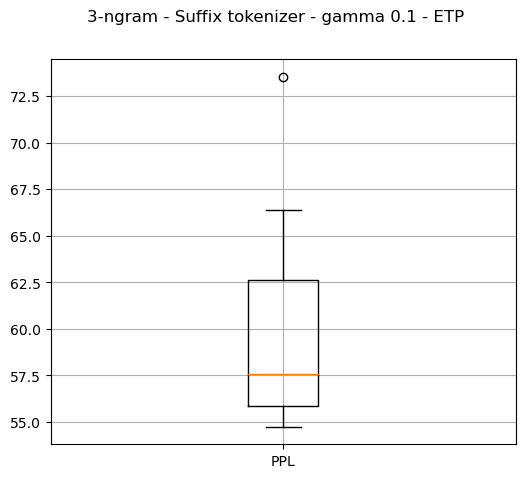

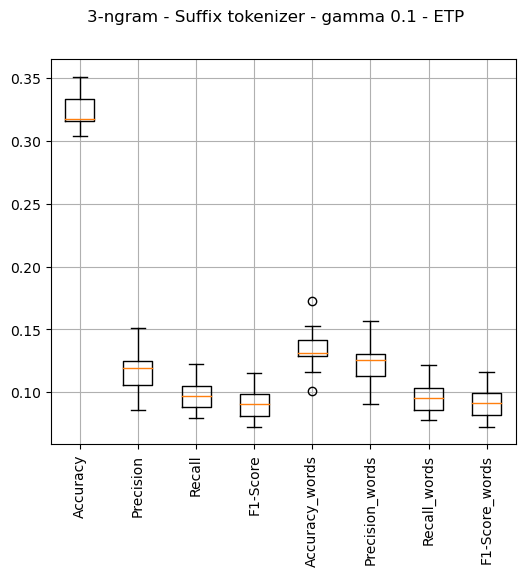

------------------------------------------------------------
3-ngram - Suffix tokenizer - gamma 0.5 - ETP 



100%|██████████| 10/10 [00:05<00:00,  1.82it/s]

Mean:
PPL                91.102245
Accuracy            0.322055
Precision           0.117800
Recall              0.097289
F1-Score            0.090072
Accuracy_words      0.132899
Precision_words     0.123112
Recall_words        0.095348
F1-Score_words      0.090420
dtype: float64
Standar deviation:
PPL                5.290261
Accuracy           0.014203
Precision          0.022039
Recall             0.013698
F1-Score           0.013800
Accuracy_words     0.020250
Precision_words    0.022440
Recall_words       0.014192
F1-Score_words     0.014367
dtype: float64
Etruscan: tite
Prediction: tite tu
Etruscan: zathrumsne lushash fler hamphisca thezeri
Prediction: zathrumsn
Etruscan: --- mvkhza
Prediction: --- m n


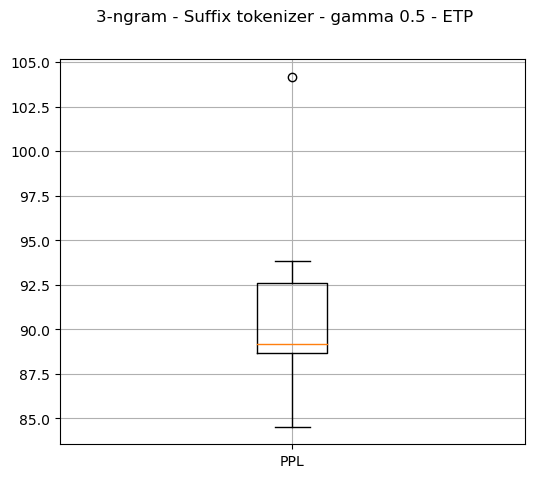

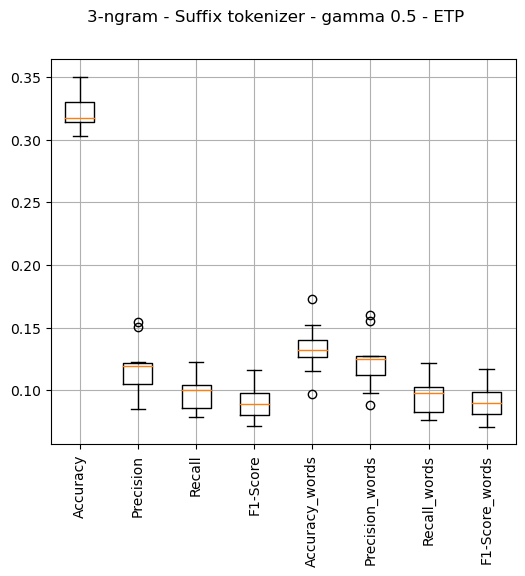

------------------------------------------------------------
3-ngram - Suffix tokenizer - gamma 1 - ETP 



100%|██████████| 10/10 [00:05<00:00,  1.77it/s]

Mean:
PPL                116.299498
Accuracy             0.320533
Precision            0.116994
Recall               0.099710
F1-Score             0.089888
Accuracy_words       0.134159
Precision_words      0.122159
Recall_words         0.097914
F1-Score_words       0.090273
dtype: float64
Standar deviation:
PPL                5.001718
Accuracy           0.014477
Precision          0.021563
Recall             0.015208
F1-Score           0.013446
Accuracy_words     0.020019
Precision_words    0.021871
Recall_words       0.015764
F1-Score_words     0.014013
dtype: float64
Etruscan: tite
Prediction: tite tu
Etruscan: zathrumsne lushash fler hamphisca thezeri
Prediction: zathrumsn
Etruscan: --- mvkhza
Prediction: --- m n


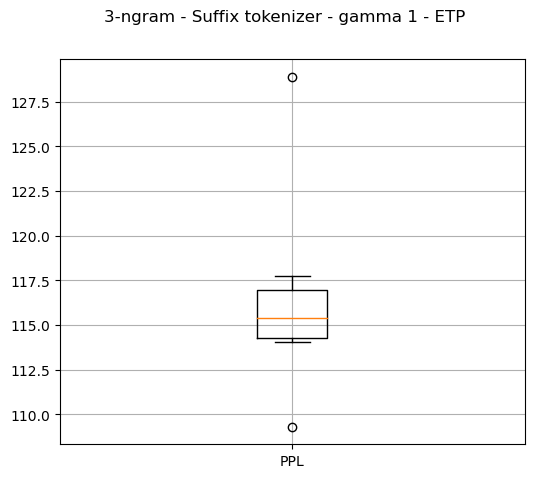

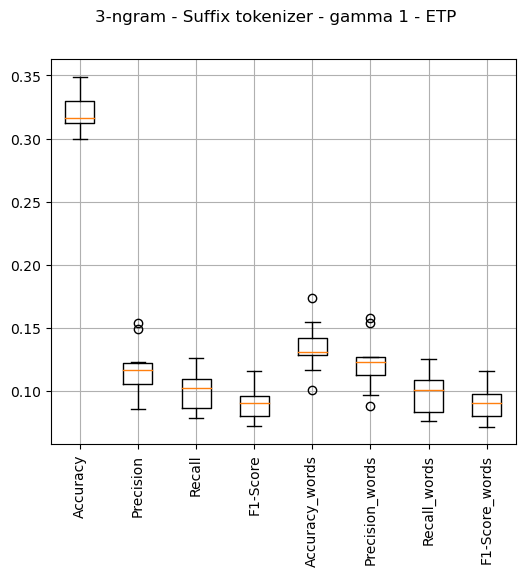

In [25]:
output = "{}-ngram - SP tokenizer - gamma {} - ETP"

do_job(order, gamma, etp, tokenizer, output)